# Assignment 07
## Clustering Models
## CSCI E-108    
  

> **Note on packages used:** The code in this notebook uses two widely-used open-source data science Python packages, Scikit-Learn and Seaborn. Some links to quick-start guides and tutorials are provided here. Please ask you instructional staff if you have additional questions or difficulties using these packages.     
> 1. The [Scikit-Learn package](https://scikit-learn.org/stable/index.html) is a core machine learning package. You can find a quick-start guide for Scikit-Learn [here](https://scikit-learn.org/stable/getting_started.html). An overview of [applying Scikit-Learn for clustering models](https://scikit-learn.org/stable/modules/clustering.html) is provided under the unsupervised learning documentation.   
> 2. The [Seaborn package](https://seaborn.pydata.org/index.html#) is a powerful data visualization package. You can find a quick-start guide to Seaborn [here](https://seaborn.pydata.org/introduction.html). Seaborn provides uses with many examples and [tutorials](https://seaborn.pydata.org/tutorial.html) on each category of charts provided.  
> 3. THe Uniform Manifold Approximation and Projection or [UMAP package](https://umap-learn.readthedocs.io/en/latest/) allows  visualization of high-dimensional data on a 2-dimensional **manifold**. You can find installation instructions for this package [here](https://umap-learn.readthedocs.io/en/latest/index.html). We will discuss manifold learning in the dimensionality reduction lesson. For the current version of the umap package it is recommend that you also install the umap-learn package by uncommetting and running the code below:
  

In [99]:
#!pip install umap
!pip install umap-learn

> 5. The [Scikit Learn Extra](https://scikit-learn-extra.readthedocs.io/en/stable/index.html) package provides several state of the art extensions to standard Scikit Learn. Here we will explore the use of the K-mediods algorithm and its more scalable derivatie, CLARA. You can find installation instructions for this package [here](https://scikit-learn-extra.readthedocs.io/en/stable/install.html).    

## Introduction    

**Clustering models** are core data mining methods. Clustering models are also known as **unsupervised learning** models. The goal of these models is to extract structure and relationships from complex data. Carrying out this type of exploration is difficult since there is no ground truth as a basis of comparison. 

In this assignment you will work with a complex human resources data set to explore the basic concepts of clustering. Specifically, you will use the [human resources (HR) dataset from Kaggle](https://www.kaggle.com/jacksonchou/hr-analytics). The business goal is to discover attributes common to employees who leave a large company prematurely. You will use multiple clustering algorithms to build an understanding of the relationships between the variables. Since we do not know in advance which attributes are important in an employees decision to leave, this is a perfect application for clustering methods.   

Evaluation of any unsupervised learning model is a difficult task at the best of times. In this assignment you will use a combination of numeric and graphical evaluation methods. The scope of model evaluation and comparison has deliberately been limited here. Many more methods can and should be applied to complex real-world problems. Regardless of the evaluation methods applied, interpretation of clustering model results remains difficult and requires judgment. 

As you proceed with the exercises, keep in mind that the relationships in this data set are complex. There are unlikely to be one or just a few simple reasons why long-term employees chooses to leave their jobs. Consequently, you should not expect simple well defined results for any analytical model. This type of difficulty and complexity is inherent in many real-world applications of unsupervised learning.    

The cluster models you will apply in this assignment have many hyperparameters. To limit the scope of the exercises, values for many hyperparameters are specified in many cases. These values were found by limited exploration of the hyperparameter space. For a real-world project a great deal more time-consuming exploration would be required. 

> **Important Note:** You will need at least 2 GB of free RAM to execute the exercises in this notebook. 


### Load and explore the data   

As a first step in this analysis, execute the code in the cell below to import the required packages. 

In [100]:
import pandas as pd
import numpy as np
import numpy.random as nr
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN, OPTICS, MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity, cosine_distances, euclidean_distances 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.datasets import load_iris
from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph
from sklearn_extra.cluster import CLARA, KMedoids, CommonNNClustering
from patsy import dmatrix
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
import math

%matplotlib inline

Next, execute the code in the cell below to import the dataset and display the data types of the columns.  

In [101]:
HR_data = pd.read_csv('HR_comma_sep.csv')
HR_data.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

There are several data types here. The first two variables have floating point numeric values. There are several integer numeric values. And, finally the last two columns appear to have categorical values.  

One question to ask about these data is how many unique levels are there in the columns which are not floating point numbers? To investigate the answer, execute the code in the cell below and examine the results.  

In [102]:
#for col in HR_data.columns[2:]:  
for col in HR_data.columns:  
    print('\n' + col)
    print(HR_data[col].unique())


satisfaction_level
[0.38 0.8  0.11 0.72 0.37 0.41 0.1  0.92 0.89 0.42 0.45 0.84 0.36 0.78
 0.76 0.09 0.46 0.4  0.82 0.87 0.57 0.43 0.13 0.44 0.39 0.85 0.81 0.9
 0.74 0.79 0.17 0.24 0.91 0.71 0.86 0.14 0.75 0.7  0.31 0.73 0.83 0.32
 0.54 0.27 0.77 0.88 0.48 0.19 0.6  0.12 0.61 0.33 0.56 0.47 0.28 0.55
 0.53 0.59 0.66 0.25 0.34 0.58 0.51 0.35 0.64 0.5  0.23 0.15 0.49 0.3
 0.63 0.21 0.62 0.29 0.2  0.16 0.65 0.68 0.67 0.22 0.26 0.99 0.98 1.
 0.52 0.93 0.97 0.69 0.94 0.96 0.18 0.95]

last_evaluation
[0.53 0.86 0.88 0.87 0.52 0.5  0.77 0.85 1.   0.54 0.81 0.92 0.55 0.56
 0.47 0.99 0.51 0.89 0.83 0.95 0.57 0.49 0.46 0.62 0.94 0.48 0.8  0.74
 0.7  0.78 0.91 0.93 0.98 0.97 0.79 0.59 0.84 0.45 0.96 0.68 0.82 0.9
 0.71 0.6  0.65 0.58 0.72 0.67 0.75 0.73 0.63 0.61 0.76 0.66 0.69 0.37
 0.64 0.39 0.41 0.43 0.44 0.36 0.38 0.4  0.42]

number_project
[2 5 7 6 4 3]

average_montly_hours
[157 262 272 223 159 153 247 259 224 142 135 305 234 148 137 143 160 255
 282 147 304 139 158 242 239 128 132 294 134

There is a variety of information types encoded in these variables.  
1. **Ordinal** integer variables. An ordinal variable has an ordered set of values. In this case, several ordinal variables are numeric. But, `salary` is coded by categories.    
2. Three **binary variables**, coded as $\{0,1 \}$.    
3. One **categorical variable**, `sales`, which are job categories. 
4. Five **numeric variables**, `satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours`, and `time_spent_company` all coded as integers.      

To better understand the numeric variables it is useful to create histograms. Execute the code in the cell below and examine the histograms displayed.     

In [103]:
HR_data[['satisfaction_level','last_evaluation', 'number_project','average_montly_hours','time_spend_company']].dtypes

satisfaction_level      float64
last_evaluation         float64
number_project            int64
average_montly_hours      int64
time_spend_company        int64
dtype: object

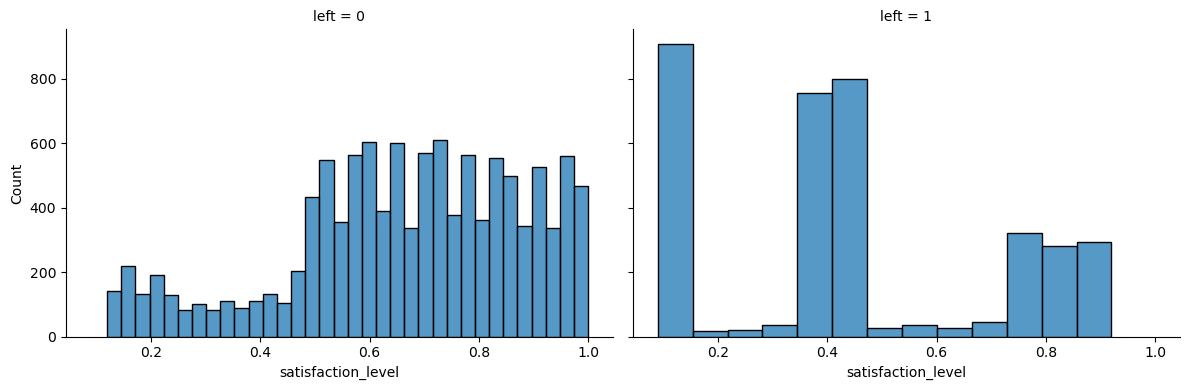

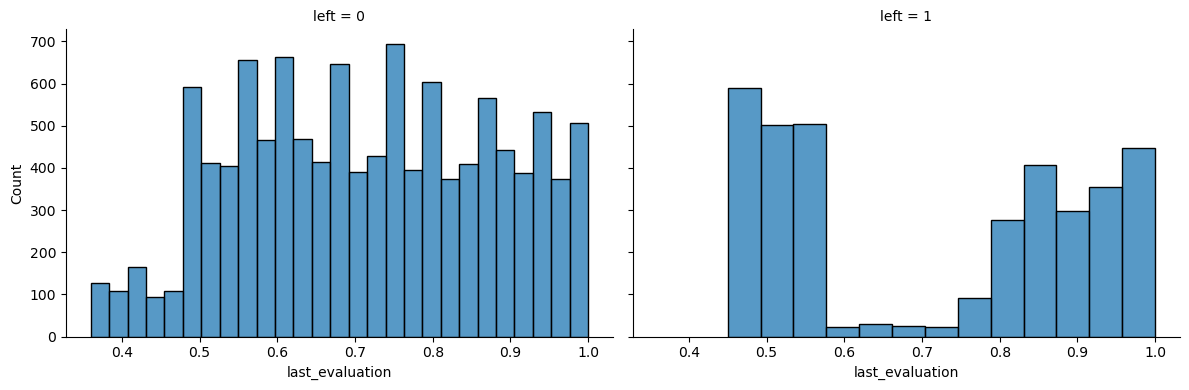

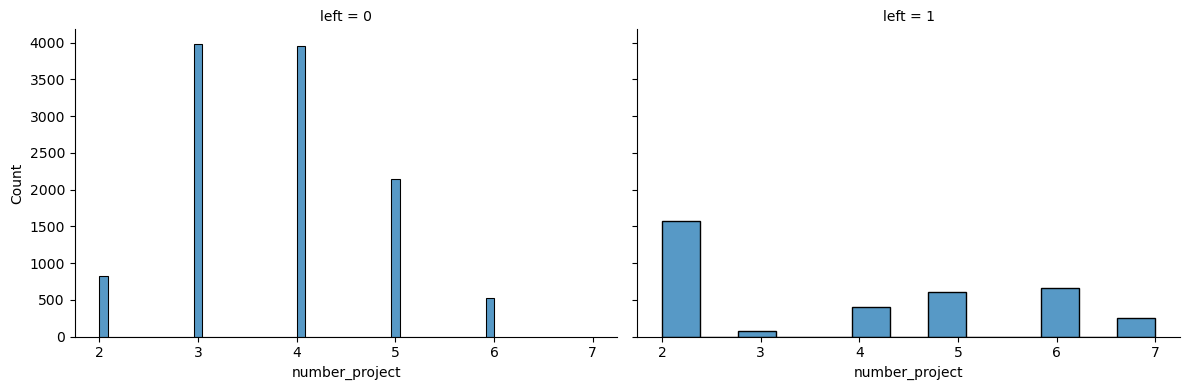

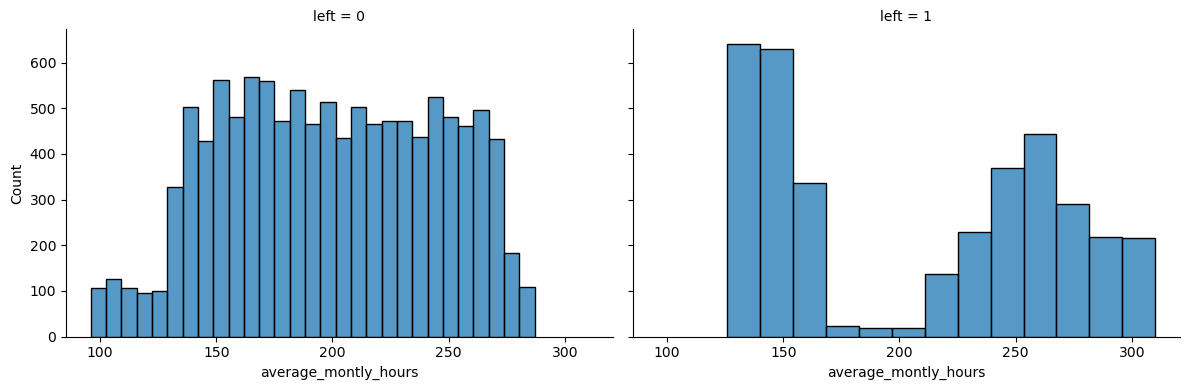

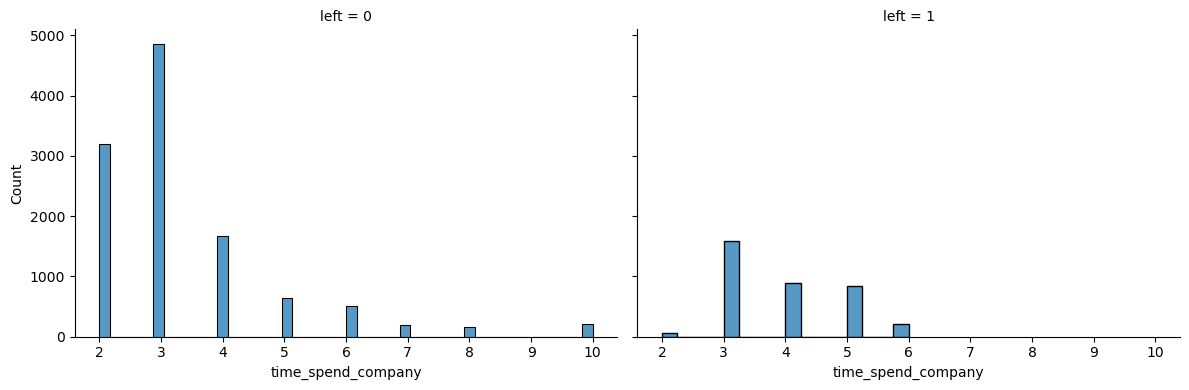

In [104]:
for col in ['satisfaction_level','last_evaluation', 'number_project','average_montly_hours','time_spend_company']:
    g = sns.FacetGrid(HR_data, col='left', height=4, aspect=1.5, subplot_kws={'alpha':0.1})
    g.map_dataframe(sns.histplot, x=col)
    plt.show()

None of these variables are remotely close to a Normal distribution. In fact, some of these variables look closer to a uniform distribution.      

Additionally, there are some differences the densities between employees who left and employees who stayed. Optimistically, these differences should help when creating cluster models to understand reasons why employees leave the company.   

### Preparing the data   

With some understanding of the variables, we must now prepare the dataset for the analysis. For clustering algorithms we must restrict ourselves to encoding that preserves our ability to compute the required distance metrics. Still there are a number possible distance metrics and encoding options we can choose from.  

For the examples in this notebook we will use data encoding suitable for Euclidean (L@) and L1 distances. The choice of Euclidean distance, in particular, dictates that we scale numeric features. Additionally, we will minimize the number of binary features.   

As a first step in this process, we must convert the ordinal variable `salary` to a numeric type. The code in the cell below limits the numeric values to the range $[0,1]$ and maintains the order. Execute this code and note the result 

In [105]:
salary_levels = {'low':0.0, 'medium':0.5, 'high':1.0}
HR_data.loc[:,'salary'] = [salary_levels[x] for x in HR_data.loc[:,'salary']]
HR_data.loc[:,'salary'].value_counts()

salary
0.0    7316
0.5    6446
1.0    1237
Name: count, dtype: int64

The `sales` variable presents a particular problem. This variable is categorical and there is no sensible ordering. There is no idea solution. In this case we will recode this variable indicating if the position is in sales or something else. This approach avoids creating a larger number of binary dummy variables. Execute the code in the cell below and examine the results. 

In [106]:
HR_data.loc[:,'sales'] = [1.0 if x=='sales' else 0.0 for x in HR_data.loc[:,'sales']]
HR_data.loc[:,'sales'].value_counts()

sales
0.0    10859
1.0     4140
Name: count, dtype: int64

About 1/3 of the employees are in sales, so this coding is reasonable from this point of view. 

Finally, we must normalize the numeric variables. Since the distribution is far from Normal, Z-score normalization is likely to be a poor choice. Instead, we will use the [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). By default, this scale transforms the scale of each variable to be in the $[0.1]$ range. Such scaling in optimal for uniformly distributed variables, and a good choice for variables that are approximately uniform.  

The code in the cell below applies the Min-Max scaler to the numeric columns. Execute this code and examine the results.  

In [107]:
normalize_cols = ['satisfaction_level','last_evaluation','average_montly_hours','number_project','time_spend_company']
HR_data.loc[:,normalize_cols] = MinMaxScaler().fit_transform(HR_data.loc[:,normalize_cols])
HR_data.head()

/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_45514/2537330412.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.28504673 0.77570093 0.82242991 ... 0.21962617 0.85981308 0.28971963]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  HR_data.loc[:,normalize_cols] = MinMaxScaler().fit_transform(HR_data.loc[:,normalize_cols])
/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_45514/2537330412.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.  0.6 1.  ... 0.  0.8 0. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  HR_data.loc[:,normalize_cols] = MinMaxScaler().fit_transform(HR_data.loc[:,normalize_cols])
/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_45514/2537330412.py:2: FutureWarning: Setting an item of incompatible dtype

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.318681,0.265625,0.0,0.285047,0.125,0,1,0,1.0,0.0
1,0.780220,0.781250,0.6,0.775701,0.500,0,1,0,1.0,0.5
2,0.021978,0.812500,1.0,0.822430,0.250,0,1,0,1.0,0.5
3,0.692308,0.796875,0.6,0.593458,0.375,0,1,0,1.0,0.0
4,0.307692,0.250000,0.0,0.294393,0.125,0,1,0,1.0,0.0


The variable values in the data frame are all in the $[0,1]$ range. No variable will dominate the models simply by having numerically large values. 

At this point, all the variables are numeric. To ensure that all the variables are floating point, execute the code in the cell below. 

In [108]:
HR_data = HR_data.astype('float64')
HR_data.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project           float64
average_montly_hours     float64
time_spend_company       float64
Work_accident            float64
left                     float64
promotion_last_5years    float64
sales                    float64
salary                   float64
dtype: object

## Visualize the HR Dataset

You will now use the **uniform manifold and projection or UMAP** algorithm to visualize the relationships in the HR dataset. In brief, the UMAP algorithm creates a low-diemsional projection of high dimensional data. In this case, the projection is on to a 2-dimensional surface in the high-dimensional space, know as a **manifold**. The UMAP algorithm seeks to preserve distance, so that distances on the low-dimensional manifold correspond to the distances in the high-dimensional spaces.   

There is a complication with this particular dataset. To understand this problem execute the code in the ell below to compute and display the eigenvalues of the covariance matrix. 

In [109]:
covariance = np.cov(np.transpose(HR_data))
eigenvalues = np.linalg.eigvals(covariance)
eigengaps = -np.diff(eigenvalues)
eigengap_ratio = np.divide(eigengaps, eigenvalues[:-1])

nan = [np.nan]
pd.DataFrame({'Eigenvalues':eigenvalues,
             'Eigengaps':np.concatenate((eigengaps,nan),axis=0),   
             'Eigengap_Eigenvalue_ratio':np.concatenate((eigengap_ratio,nan),axis=0)})

,Eigenvalues,Eigengaps,Eigengap_Eigenvalue_ratio
0,0.211176,0.011630,0.055070
1,0.199547,0.081363,0.407738
2,0.118184,0.008520,0.072095
3,0.109663,0.012498,0.113963
4,0.097166,0.033847,0.348347
5,0.063318,0.022743,0.359189
6,0.040575,0.007646,0.188442
7,0.032929,0.003640,0.110541
8,0.029289,0.009127,0.311630
9,0.020162,NaN,NaN


Notice that the eigenvalues are in a narrow range. The differences between each ordered pair of eigenvalues is called the **eigengap**. The ratio of the eigengap to the larger eigenvalue is shown inj the right column displayed. Notice that this ratio is quite small for the first eigenvalue pair. This result indicates that the eigengap is generally small and the projections to the low-demensional maniforld may not be well defined.          

Next, execute the code in the cell below to compute the UMAP embedding of the HR data frame.    

In [110]:
np.random.seed(4365)
reducer = UMAP()
HR_embedding = reducer.fit_transform(HR_data)

/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Indeed, the small eigengap has caused the UMAP algorithm convergence problems. As a result an alternate initialization method has been used. None the less, an low-dimensional embedding has been computed.      

To display the samples projected on the comptued manifold, execute the code in the cell below.  

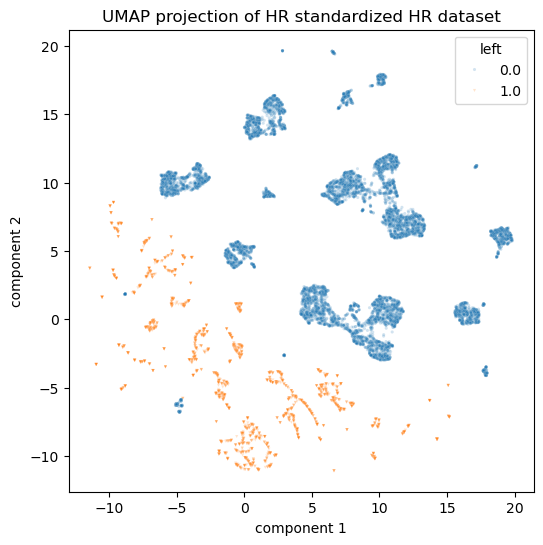

In [111]:
HR_embedding_df = pd.DataFrame(HR_embedding, columns = ['component1', 'component2'])
HR_embedding_df['left'] = HR_data.loc[:,'left']

fig,ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=HR_embedding_df, x='component1', y='component2', 
                hue='left', style='left', markers=['o','v'],
                s=5, alpha=0.2, ax=ax);
ax.set_xlabel('component 1');
ax.set_ylabel('component 2');
ax.set_title('UMAP projection of HR standardized HR dataset');

The UMAP projection shows good separation between the characteristics of employees who left the company and those that did not. There are a few non-leaving observatons that overlap the region of the manifold occupied by the leaving observations.   

At a more detailed level notice the clumping of the observatons. For example, the non-leaving observations are in fairly tight groups with considerable separation.    

## K-Means Clustering  

K-means clustering separates a dataset into K clusters of equal variance. The number of clusters, K, is user defined. The basic algorithm has the following steps:
1. A set of K centroids are randomly chosen. 
2. Clusters are formed by minimizing variance within each cluster. This metric is also know as the **within cluster sum of squares** (see further discussion in the section on evaluating clusters). This step partitions the data into clusters with minimum squared distance to the centroid of the cluster. 
3. The centroids are moved to mean of each cluster.    
4. The means of each cluster is computed and the centroid is moved to the mean. 
5. Steps 2, 3 and 4 are repeated until a stopping criteria is met. Typically, the algorithm terminates when the within cluster variance decreases only minimally. 
6. The above steps are repeated starting with a random start of step 1. The best set of clusters by within cluster variance and between cluster separation are retained.  

Since K-means clustering relies only on basic linear algebra operations, the method is fairly scalable. Out-of-core K-means clustering algorithms are widely used to increase the size of datasets which can be clustered. However, this method assumes equal variance of the clusters, a fairly restrictive assumption. In practice, this criteria is almost never true, and yet K-means clustering still produces useful results. 

### K-means clustering example

Let's try a simple example, applying the k-means algorithm to the prepared HR data. In this case we will use the [sklearn.clustering.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) package to compute cluster assignments using $k=4$.  

The code in the cell below creates a [k-means cluster object](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans), and computes the cluster assignments with the `fit_predict` method. A frequency table of the cluster assignments by the value of the `left` variable is then displayed. Execute this code and examine the results.     

In [112]:
nr.seed(4455)
HR_data['cluster_assignments'] = KMeans(n_clusters=4, n_init=10).fit_predict(HR_data)
## Create a frequency table of the number of employees leaving by cluster assignment  
HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index()

cluster_assignments  left
0                    0.0     2000
                     1.0       86
1                    1.0     2517
2                    0.0     6843
3                    0.0     2585
                     1.0      968
Name: count, dtype: int64

Notice that most of the employees who left the company are in a single cluster. Further, there are no assignments to this cluster of employees who did not leave. This appears promising in terms of understanding employees who leave.   

Using this analysis, we can consider which factors are important in compelling employees to leave the company. Visualization of clustering results can be difficult, but with some effort important insight can be gained. Like most data visualization, a number of ideas must be tested. Most visualizations will not be that useful, but a few will be. Consistent with the prime rule of data mining, **try lots of ideas, fail fast, keep the few ideas that work**.    

For this case, we will start by displaying a UMAP projection of the cluster assignments. Such a projection allows one to determine the relationship between the clusters in the manifold space. Ideally, on the manifold projection the clusters should be both compact and well separated. Execute the code and examine the results.  

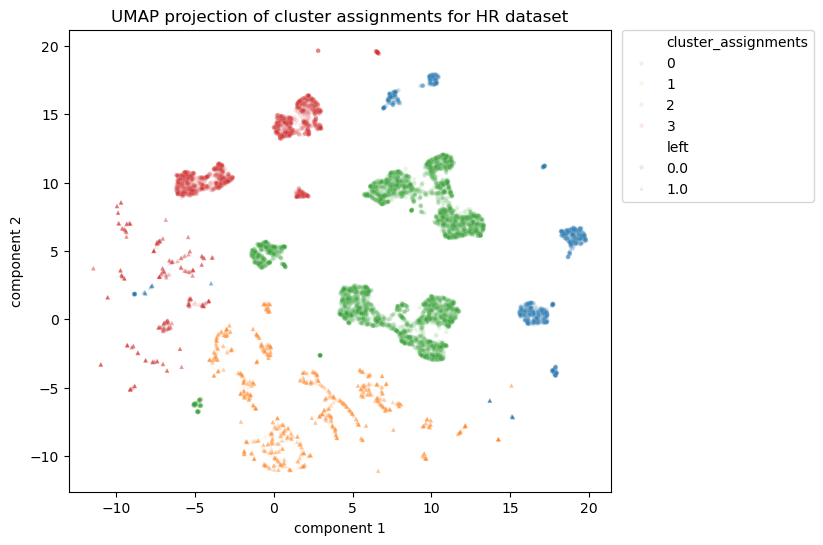

In [113]:
def plot_cluster_assignments(df, cluster_assignments):
    if 'lift' in HR_embedding_df.columns: HR_embedding_df.drop(['left'], axis=1, inplace=True)
    df['cluster_assignments'] = cluster_assignments.astype('category')
    fig,ax = plt.subplots(figsize=(7,6))
    sns.scatterplot(data=df, x='component1', y='component2', 
                    hue='cluster_assignments', style='left', 
                    markers=['o','^'], s=10, alpha=0.1, ax=ax);
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_xlabel('component 1');
    ax.set_ylabel('component 2');
    ax.set_title('UMAP projection of cluster assignments for HR dataset');

plot_cluster_assignments(HR_embedding_df, HR_data['cluster_assignments'])

There are several observations one can make from this display:    
1. The clustering has generally separated the leaving and non-leaving employees. This observation is consitent with the frequency table discussed previously. From this point of view, the cluster model is suscussful and might provide insight into the differences between the two populations.   
2. However, the clusters are not compact. Notice that each of the four clusters includes several clumps of tight groups of observations. This observation indicates that a model with more clusters is likely required.   

> **How to interpret a violin plot:** You may not be familar with violine plots. Violin plots were introduced in readable paper by [Heintze and Nelson](https://www.stat.cmu.edu/~rnugent/PCMI2016/papers/ViolinPlots.pdf) as a more informative improvment over the familar boxplot.    
> 
> The violin plot retains the attributes of the familar [**boxplot**](https://en.wikipedia.org/wiki/Box_plot). On the box plot a dot shows the median of the observaions. The inner quartiles are represented by the box. The outer quartiles are shown by the 'wiskers'. 
> 
> The 'violin' on violin plot is a pair of back-to-back [**kernel density estimation (KDE)**](https://en.wikipedia.org/wiki/Kernel_density_estimation) curves. These curves show an emperical estimate of the density of sample values. The KDE curves are normalized to have unit area. This means that even classes with small numbers of observations will have the same total area as curves for curves representing large numbers of samples.    
> 
> Displaying emperical distribution information using the two methods described above methods allows one to visualize quite a bit of information. The box plot retains the ability to show quartiles of the denisty, in the same familar maner as a box plot. But, whereas box plots cannot show the properties of multi-modal densities, the violin plot can from the KDE curves. As is commonly done with box plots, violin plots can be arrange side by side for comparing densities of different variables.      

Next, we will display and examine some [violin plots](https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot). Execute the code in the cell below to display violin plots of satisfaction level, number of projects, average monthly hours, time at the company, and salary by cluster assignment. Hue is used to show the left variable. These variables are chosen since they seem likely to provide some insight into why employees might leave the company. 

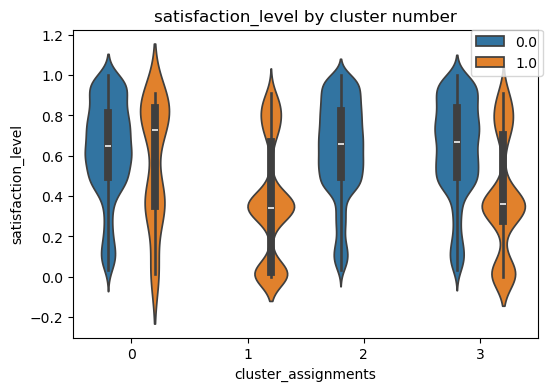

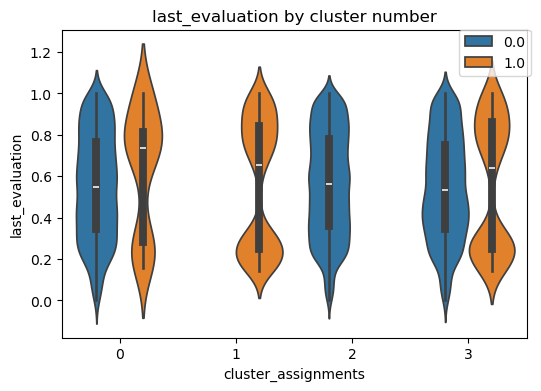

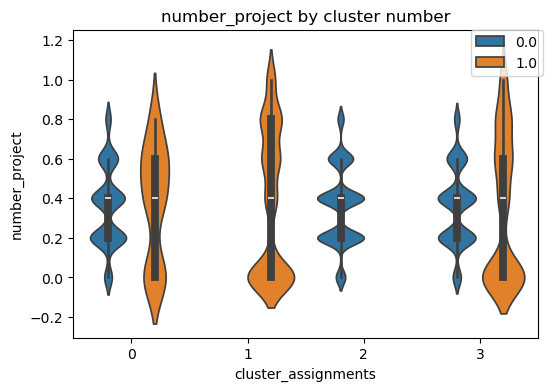

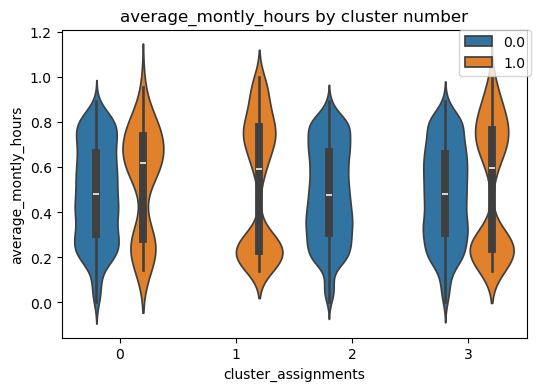

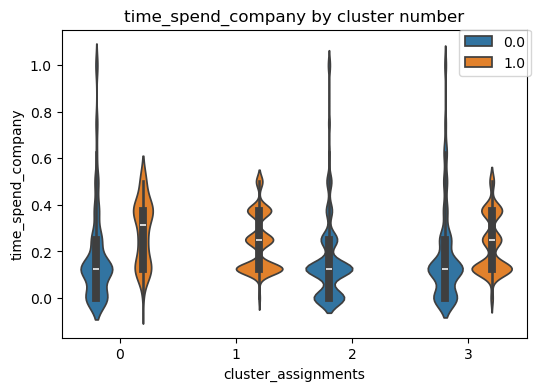

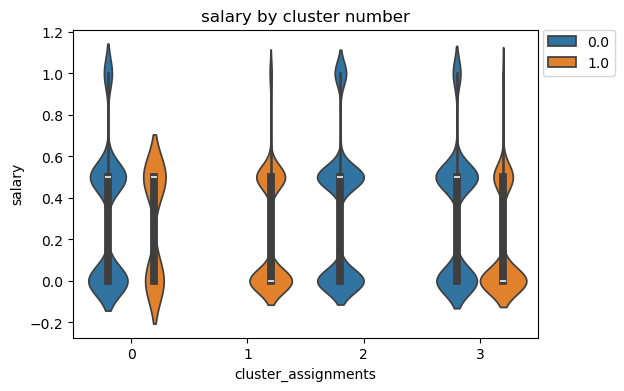

In [114]:
def plot_clusters_by_factor(df, factor='satisfaction_level', type='violin'):
    plt.figure(figsize=(6,4))
    if(type=='violin'):
        ax=sns.violinplot(x='cluster_assignments', y=factor, hue='left', data=df)
    else: 
        ax=sns.boxplot(x='cluster_assignments', y=factor, hue='left', data=df)
    ax.set_title(factor + ' by cluster number')
    plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
    
plot_columns = ['satisfaction_level','last_evaluation', 'number_project','average_montly_hours','time_spend_company', 'salary']    
for factor in plot_columns:
    plot_clusters_by_factor(HR_data, factor=factor)    

Some interesting paterns emerge in these plots:   
1. Not surprisingly, many of the leaving employees have low satisfaction levels as can be seen from the low median for leaving employees of cluster 2. Howeever, a similar number of leavers have high satisfaction level as can be seen by the relatively high median for leaving employees in cluster 1. Evidently, satisfaction level alone is not the sole reason for employees leaving.     
2. The time of laat evaluation for employees levaing is bimodal. Apparevely employees with recent evaluations and those who have not had one for a while are most likely to leave. Notice that the median of the cluster 2 leaving employees have a fairly recent review where as the leaving employees in cluster 1 have a long time since a review. In contrast, most of the non-leavers have a wide range of time from review with a median near the center of the standardized variable. Again, this variable alone does not completely explain why employees leave.     
3. The relationships for number of projects and number of hours worked per month show some further differentiation of the clusters. The leaving employees tend to have the largest and least numbers of projects and hours as can be seen from the bimodal distributions. Notice also that leaving employees 2 have a low median number of projects and hours. This seems reasonable for employees leaving the company. In contrast, the non-leaving employees have numbers of project and hours closer to the median.   
4. Leaving employees in cluster 1 have a realtively long median time with the company.    
5. Leaving employees in clusters 1 and 2 have a relatively low median salary.     

In summary, we can say that emplyees leaving the company come in two different groups with distinct characteristics. This information could be used by the company to identify employees in these groups and take steps to prevent them leaving proactively.   

## Evaluating cluster models

Now that you have created some clustering models, you are likely wondering how can you evaluate these models and perform model selection. There are a number of metrics you can use to evaluate and compare clustering models. However, you should always keep in mind that the best model, should be selected based on the problem you are trying to solve.

### Evaluating sum of squares metrics

One useful metric for clusters is the **within cluster sum of squares** or **WCSS**. Intuitively, clusters should have minimal dispersion and therefore minimal WCSS. The  

$$WCSS = Min \sum_i \sum_{j\ in\ cluster\ i} ||x_j - c_i||^2 \\
where\\
c_i = center\ of\ ith\ cluster\\ 
and\\
||x_j - c_i|| = distance\ between\ data\ x_j\ and\ center\ c_i
$$

We can use WCSS to compare different cluster models based on Euclidean distance measures. Models with smaller SSW have tighter clusters and, therefore smaller WCSS. 


> **Note:** WCSS is also referred to as **inertia**, an analogy with classical mechanics in physics. 


The **between cluster sum of squares** or **BCSS** is a related metric, useful for models using Euclidean distance measures. Whereas WCSS measures how tight the clusters are BCSS is a measure of the separation between the clusters. To compute the BCSS, observe that the **total sum of squares** or **TSS** must equal the sum of the WCSS and BCSS:

$$
TSS = BCSS + WCSS\\
where\\
TSS = \sum_i (x_i - \mu)^2\\
where\\
\mu = mean\ of\ all\ data\ samples
$$

Notice that the TSS is just the variance of all data points. And, BCSS is then just the difference between TSS and WCSS.


> **Note:** The WCSS and BCSS metrics have the concept of the clustering having multivariate-Normal distributions. Therefore, these metrics are strictly only applicable to cluster algotithms using Euclidean distance metrics. This fact means that WCSS and BCSS are not useful metrics for agglomerative clustering. The SC can be computed using various metrics so is more generally applicable to most clustering methods. 

### Silhouette coefficient

Another possibile measure for evaluation of clusters is the **silhouette cofficient**, which is computed from the key measures of the clusters:    
- **a:** the mean distance between a sample and all other samples in the cluster, or a measure of **cluster compactness**.   
- **b:** the mean distance between a sample and all other samples in the next nearest cluster, or a measure of **cluster separation**. 

Any distance measure can be used to compute the silhouette coefficient. Therefore, this metric is useful for both Euclidean and non-Euclidean spaces.   

For a clustering model with $N$ samples, the mean silhouette cofficient is then:     

$$S = \frac{1}{N} \sum_{i=N}^N \frac{b - a}{max(a,b)}$$

How can we interpret the silhouette coefficient. The numerator is the difference of the between cluster and within cluster distances. The numerator is normalized by the larger of these two differences. Therefore, we can interpret the silhouette coefficient as the normalized difference of difference of the between cluster and within cluster distances. Given this interpretation, we can say that larger silhouette coefficient is generally better. But be careful, large silihouette coefficients can sometimes arrise from fragmentation of the data into a large number of generally meaningless clusters.    

### Calinski-Harabasz Index     

The Calinski-Harabasz index is a **degree of freedom adjusted** variance ratio. The variance is taken from the trace of the BCSS and WCSS matrices. The trace of a matrix is the sum of the diagonal terms. For BCSS and WCSS the trace is the sum of the cluster-wise variances.   

The Calinski-Harabasz index for the $ith$ cluster is writen:    

$$CH_i = \frac{tr(BCSS)\ n_e - k}{tr(WCSS)\ k-1}$$     
Where:    
$n_e =$ is the total number of observations.   
$k =$ the number of clusters.   

### Finding the number of clusters

We have investigated our first k-means cluster model with $k = 4$. The next question is, how many clusters ($k$) are optimal. As we are dealing with unsupervised learning models the answer is generally not obvious. 

One approach to determining the number of clusters is to plot several metrics against the number of clusters. In this case you will use WCSS, BCSS, silhouette coefficient and Calinski-Harabasz index. The code in the cell below creates just such a plot by the following steps:
1. Any existing cluster assignments are removed from the data frame. It is critical that assignments from other models not bias the training of the new models. 
2. Lists are defined to save the metrics computed for each value of $k$.
3. A loop interates over the specified range of $k$ values. 
4. For each value of $k$ **inertia** or WCSS, BCSS, silhouette coefficient, and Calinski-Harabasz index are computed and saved. The `inertia` attribute of the model, along with the [silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) and [calinski_harabasz_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html) functions are used to compute these metrics.  
5. An array of plots are displays WCSS, BCSS, silhouette coefficient and Calinski-Harabasz index vs. the number of clusters. 

Execute this code and examine the result.

/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


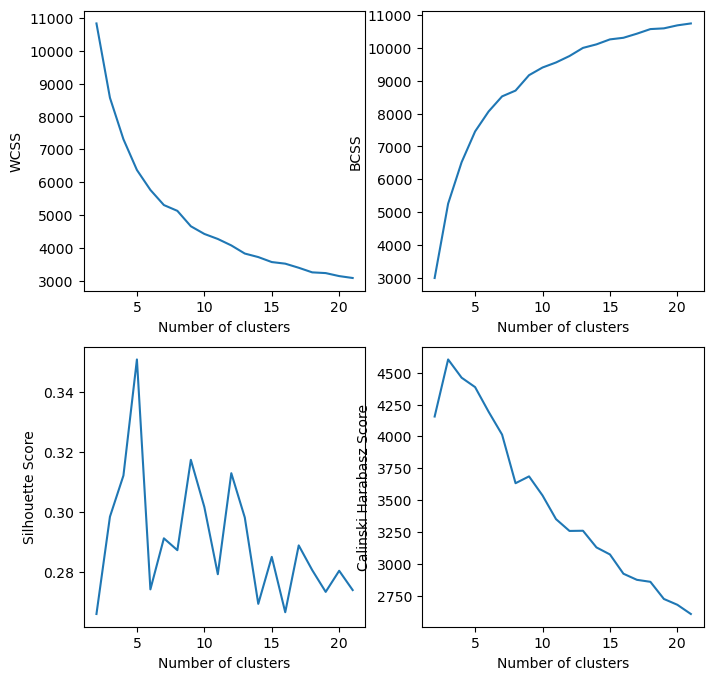

In [115]:
def cluster_search_kmeans(df, nclusts=(2,21), n_init=10):
    ## If there are cluster assignments in the data frame remove them. 
    if 'cluster_assignments' in df.columns: df.drop(columns='cluster_assignments', inplace=True)
    WCSS=[]
    BCSS=[]
    silhouette=[]
    CH_index = []
    ## Compute total sum of squares
    x_bar = np.mean(df, axis=0)
    TSS = np.sum(np.sum(np.square(df - x_bar)))
    for n in range(nclusts[0],nclusts[1]+1):   
        temp_model = KMeans(n_clusters=n, n_init=n_init).fit(df)
        WCSS.append(temp_model.inertia_)
        BCSS.append(TSS - temp_model.inertia_)
        assignments = temp_model.predict(df)
        silhouette.append(silhouette_score(df, assignments))
        CH_index.append(calinski_harabasz_score(df, assignments))
    _, ax = plt.subplots(2,2, figsize=(8,8))    
    ax = ax.flatten()
    ax[0].plot(range(nclusts[0],nclusts[1]+1),WCSS)   
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    ax[1].plot(range(nclusts[0],nclusts[1]+1),BCSS)   
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('BCSS')
    ax[2].plot(range(nclusts[0],nclusts[1]+1),silhouette)   
    ax[2].set_xlabel('Number of clusters')
    ax[2].set_ylabel('Silhouette Score')
    ax[3].plot(range(nclusts[0],nclusts[1]+1),CH_index)   
    ax[3].set_xlabel('Number of clusters')
    ax[3].set_ylabel('Calinski Harabasz Score')
 
nr.seed(9966)
cluster_search_kmeans(HR_data)    

As expected, the slope of the WCSS curve drops rapidly as the number of clusters increases, while the BCSS curve increases rapidly. The silhouette coefficeint has two peaks. One peak occurs where the slope of WCSS and BCSS is still quite high, but changing fairly rapidly. At the second peak, at 10 clusters, the slopes of BCSS and WCSS is considerably less. Notice that the difference in numerical value of these two peaks is quite small. The Calinski-Harabasz index has one distinct peak at $k=4$, but nearly the same value at $k=5$ The question is, where is the best cutoff that leads to an informative, but not over-fit model? This choice is partially subjective. In a more detailed analysis, several models can be compared. In this case, a comprimise of $k=5$ is likely to be the best choice.  

### Exploring model results

> **Exercise 07-1:** In the cell below create and execute code to do the following: 
> 1. Make sure you first remove the `cluster_assignments` column from the data frame if present. 
> 2. Use the `%time` IPython magic as a prefix of the line of code creating the cluster model. 
> 3. Compute an k=5 cluster model for the HR dataset, using the `fit_predict` method, and assign the clusters from the model to a 'cluster_assignments' column in the HR data frame.  
> 4. Display a frequency table of cluster assignments by value of the `left` variable

In [116]:
nr.seed(7722)
## Put your code below
if 'cluster_assignments' in HR_data.columns: HR_data.drop(columns='cluster_assignments', inplace=True)

%time kmeans = KMeans(n_clusters=5, n_init=10)
%time HR_data['cluster_assignments'] = kmeans.fit_predict(HR_data)

## Display the frequence table by cluster assignment
HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)

CPU times: user 7 μs, sys: 1 μs, total: 8 μs
Wall time: 11 μs
CPU times: user 1.31 s, sys: 344 ms, total: 1.65 s
Wall time: 163 ms


cluster_assignments  left
0                    0.0     2000
                     1.0       15
1                    0.0     6843
2                    1.0     1620
3                    1.0     1936
4                    0.0     2585
Name: count, dtype: int64

> Examine the frequency table and answer the following questions:  
> 1. Are there clusters which contain the majority of records for the employees who left the company?  
> 2. Do the foregoing clusters contain any records for employees who stayed with the company?    
> 3. Given your answers to the foregoing questions, do you think the model can provide useful insight into characteristics of customers who leave the company?     
> **End of exercise.**


> **Answers:**    
> 1. Clusters 2 and 3 with 1620 and 1936 each, contain the majority of record of employees who left.        
> 2. No, these clusters do not contain any records for employees who stayed with the company. Both clusters 2 and 3 exclusively contain employees who left.     
> 3. Yes, the model can provide useful insights into the characteristics of employees who leave the company. Since clusters 2 and 3 exclusively contain employees who left, we can analyze these clusters to identify the distinguishing features and attributes that might be associated with employees who are more likely to leave.     

> **Exercise 07-2:** To further evaluate the model you have computed, create execute the code in the cell below to display the UMAP plot using the `plot_cluster_assignments` function.   

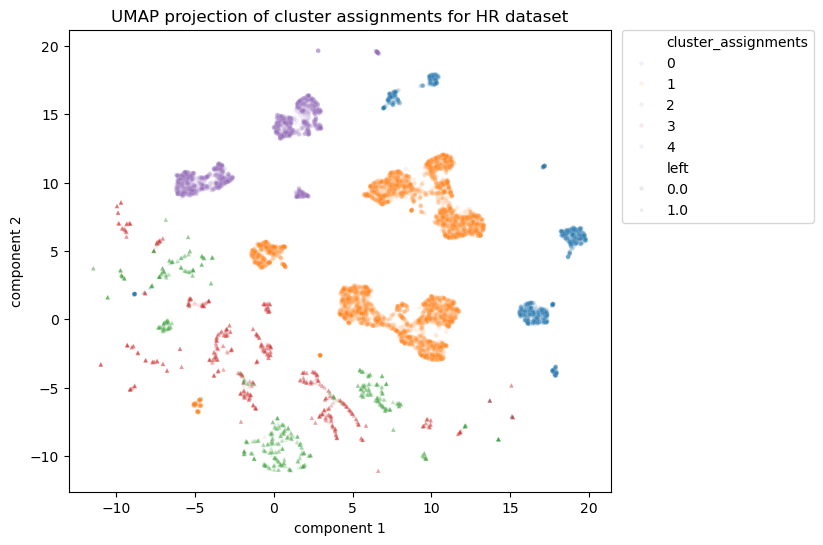

In [117]:
plot_cluster_assignments(HR_embedding_df, HR_data['cluster_assignments'])

> 1. Examine the plot. Do the clusters which contain the majority of records of employees who have left the company appear in reasonably tight clusters on the UMAP projection?     

> **Answer:** No, they still appear dispersed and not concentrated enough, which may suggest that k=5 is still too small. 

> Next, you will display and examine some violin plots. Create and execute the code in the cell below to display violin plots of satisfaction level, number of projects, and average monthly hours by cluster assignment. Hue is used to show the left variable. These variables are chosen since clusters containing records of employees who left the company are in a reasonably small range along these axes in the scatter plot matrix. 

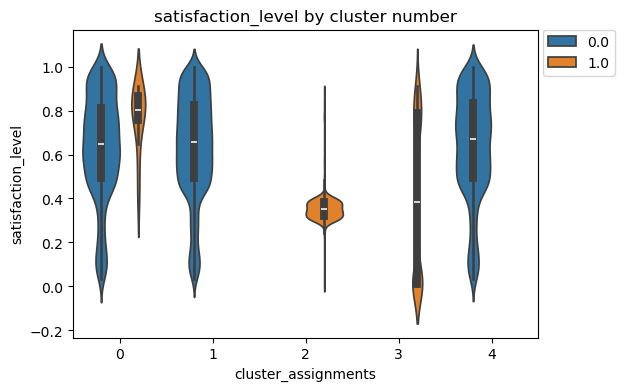

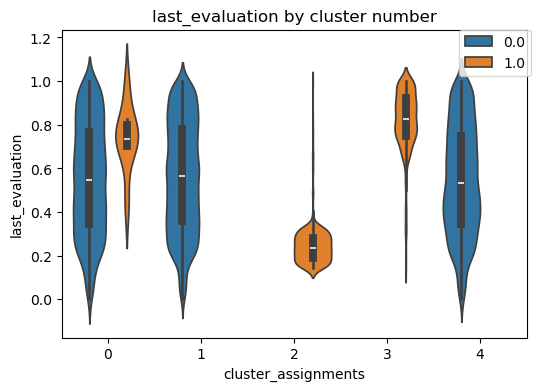

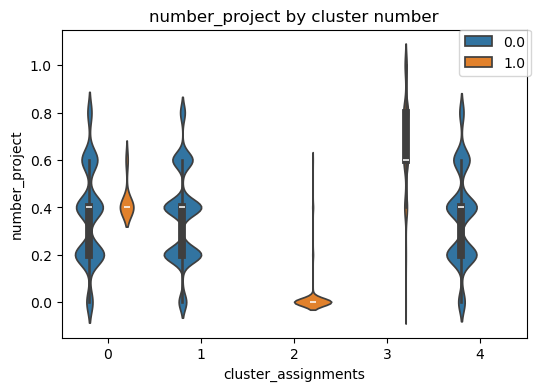

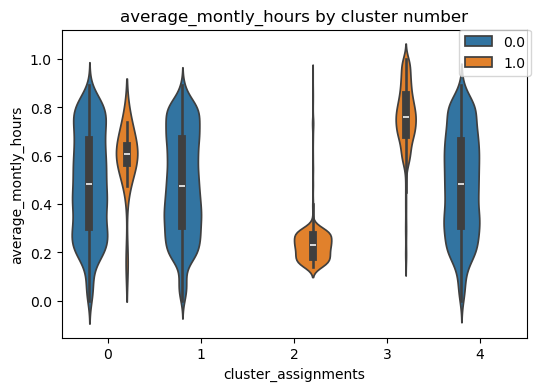

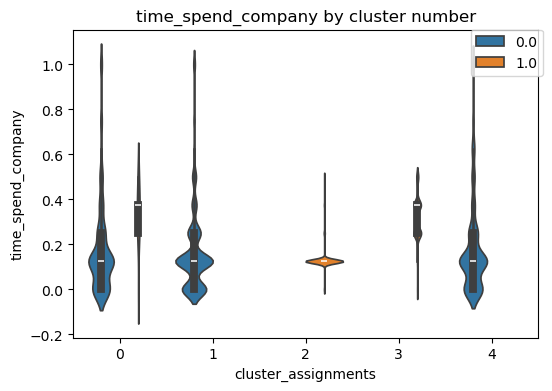

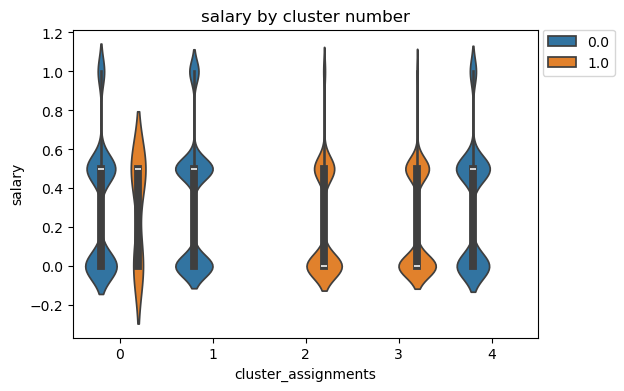

In [118]:
## Put your code below
for factor in plot_columns:
    plot_clusters_by_factor(HR_data, factor=factor)   

> We can make some inferences from these results. Unsurprisingly, employees leaving tend to have the lowest satisfaction scores. But is this always the case, or is there something else prompting employees to leave? Answer the following question:  
> 2. What can you say about the effect of high and low numbers of projects on the likelihood of an employee leaving?   
> 3. What can you say about the effect of high and low average monthly hours worked on the likelihood of an employee leaving?     
> **End of exercise.**

> **Answers:**    
> 2. Employees leaving are on the extremes, either very high number of projects worked or very low number of projects worked.    
> 3. Employees leaving are on the extremes, either very high number of monthly hours worked or very low number of monthly hours worked.

## Mini-Batch K-Means

The mini-batch K-means algorithm follows the same steps as the conventional (Batch) K-means algorithms. However at each step, a randomly selected mini-batch is used to update cluster centers and cluster assignments. This algorithm iterates through mini-batches until convergence. 

> **Exercise 07-3:** You will now create and benchmark code to implement the mini-batch K-means algorithm. You will use the [sklearn.clustering.MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) function. Use the arguments `n_clusters=5`, `batch_size=512`, and `n_init=10`, using the `fit_predict` method, and assign the clusters from the model. Use the `time.process_time` function to capture the execution time. When the cluster calculation is completed, generated and print the frequency table of the cluster assignments.    

> **Note:** If you are on Windows, you will likely see a warning concerning a known memory leak in the MiniBatchKMeans function. Since you only runing this function once on a small dataset, it is safe to ignore this warning. 

In [119]:
nr.seed(7722)
## Put your code below
if 'cluster_assignments' in HR_data.columns: HR_data.drop(columns='cluster_assignments', inplace=True)

# Initialize MiniBatchKMeans model
n_clusters = 5
batch_size = 512
n_init = 10

# Capture the start time
start_time = time.process_time()

mini_batch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, n_init=n_init)

# Fit the model and predict the cluster assignments
HR_data['cluster_assignments'] = mini_batch_kmeans.fit_predict(HR_data)

# Capture the end time
end_time = time.process_time()

# Print the execution time
print(f"Execution time for Mini-Batch K-Means: {end_time - start_time} seconds")


## Print the frequency table by cluster assignments
HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)


Execution time for Mini-Batch K-Means: 0.5632080000000315 seconds


cluster_assignments  left
0                    0.0     6843
1                    0.0     2585
2                    0.0     2000
                     1.0       14
3                    1.0     1629
4                    1.0     1928
Name: count, dtype: int64

> Examine your results and answer these questions:  
> 1. Compare the execution time of the full batch k-means algorithm to the execution time for the batch K-means. How does the run-time of the mini-batch algorithm compare to the full batch k-means algorithm and is this expected?   
> 2. Compare the number of assignments of cases of leaving employees assigned to clusters with predominantly cases of non-leaving employees to the same labeled cases for the k=5 full batch algorithm. What can you say about the mini-batch solution vs. the full batch solution and why is this behavior expected?       
> **End of exercise.**

> **Answers:**    
> 1. The Mini-Batch K-Means is running faster compared to the full batch k-means at 0.75seconds vs 2.25seconds. This is expected as in general, the Mini-Batch K-Means algorithm is expected to be faster due to its use of random mini-batches for updates rather than the entire dataset at each iteration. 

> 2. The distribution of cluster assignments for leaving employees is similar, however, Mini-Batch K-Means may produce slightly different cluster assignments due to the stochastic nature of mini-batch updates, including clusters with mixed labels (both leaving and staying employees) due to the randomness in the updates. 
This behavior is expected because the mini-batch algorithm uses only a subset of the data to update the centroids at each iteration, leading to potential variations in cluster assignments compared to the full batch algorithm, which uses the entire dataset at each iteration.

## Introduction to Hierarchical Clustering

Another widely used form of clustering uses hierarchical modes. These models attempt to divide or partition the data following a hierarchical sequence. 

Hierarchical clustering models produce a tree-like organization of the data into a hierarchy of clusters. At the root of the tree, all data cases are in one large cluster. The leaves of the tree each have a cluster with a single data case.

Hierarchical clustering models generally use one of two approaches. 

1. **Agglomerative clustering** works from the leaves of the tree toward the root in the following way.
  - All data cases start in their own cluster. 
  - Pairs of clusters are merged to their nearest neighbors over several iterations. 
  - The second step is repeated until there is one cluster at the root of the tree. 
2. **Divisive clustering** works from the root of the tree toward the leaves in the following way.
  - All data cases start in a single large cluster. 
  - Clusters are split into two parts in a way that maximizes the distance (or dissimilarity) between the clusters. 
  - The second step is repeated until there the leaves of the tree, each with a single data case, is encountered. 
  
  
With the above descriptions of the algorithms in mind, we need to discuss how distance is measured. 

First, we select a **distance metric** to compute the distance between two individual data points. We have already encountered some of the most widely used metrics, **Euclidean** and **Manhattan**. 

Since clusters are typically made up of multiple points we need a way to combine the distances between the points in clusters. We do this through **linkage functions**. There are several commonly used linkage functions. For a distance metric value between two points, $a$ in the one cluster, and $b$ in the other cluster, $D(a,b)$, we can define some common linkage functions:

1. **Ward's method** is a linkage method that uses a minimum variance criteria to select the pairs of smaller clusters to link. Since this method is based on variance, it is only defined for Euclidian spaces.     
2. **Maximum or complete linkage** is the largest value of the distance metric between any pairs of points in the two clusters. 
$$= Max \big( D(a,b) \big)$$
3. **Minimum or single linkage** is the smallest value of the distance metric between any pairs of points in the two clusters. 
$$= Min \big( D(a,b) \big)$$
4. **Mean or average linkage** is the average of the distance metrics between all pairs of points in the two clusters.
$$= \frac{1}{N_{ab}} \sum D(a,b)\\ 
where\\
N_{ab}\ is\ the\ count\ of\ pair-wise\ distances$$
5. **Centroid linkage** is the distance metric between the centroids between the two clusters. 
$$= |c_1 - c_2|\\
where\\
c_1, c_2\ are\ centroids\ of\ clusters\ 1\ and\ 2$$

As you can imagine, the choice of distance metric and linkage function can significantly change the clustering relationships a model finds. There are some restrictions on this choice one should always keep in mind. Ward's method is only optimal for Normally distributed data and centroid linkage assumes a Euclidean space. Complete-linkage, single linkage and average linkage are all applicable to non-Euclidean spaces. In other words, the linkage method selected must match the properties of the distance metric being used and vice versa.      

### Agglomerative clustering example   

With the foregoing theory in mind, its time to try an example using the HR dataset. We have already explored k-means clustering on this dataset. Recall that the k-means method is only defined for the Euclidean distance metric.  

The agglomerative clustering algorithm, like all hierarchical clustering algorithms, Allows the choice of both a linkage method and a range of distance metrics. In this first example we will use complete linkage which uses the maximum distance between any two points within two clusters. We will also use the Manhattan (L1) distance metric.  

The code in the cell below creates and fits an agglomerative cluster model and then displays the resulting frequency table. Execute this code and examine the results.

In [120]:
nr.seed(2356)
if 'cluster_assignments' in HR_data.columns: HR_data.drop(columns='cluster_assignments', inplace=True)
model_agglomerative =  AgglomerativeClustering(n_clusters=4, linkage='complete', metric='manhattan',
                                              compute_full_tree=False)   
HR_data['cluster_assignments'] = model_agglomerative.fit_predict(HR_data)
HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)

cluster_assignments  left
0                    0.0     8114
1                    0.0     3031
                     1.0      497
2                    1.0     3073
3                    0.0      283
                     1.0        1
Name: count, dtype: int64

There is one cluster containing most of the records of the employees who left the company.   

Execute the code in the cell below to create the scatter plot matrix of some of the variables with the hue showing cluster assignments. 

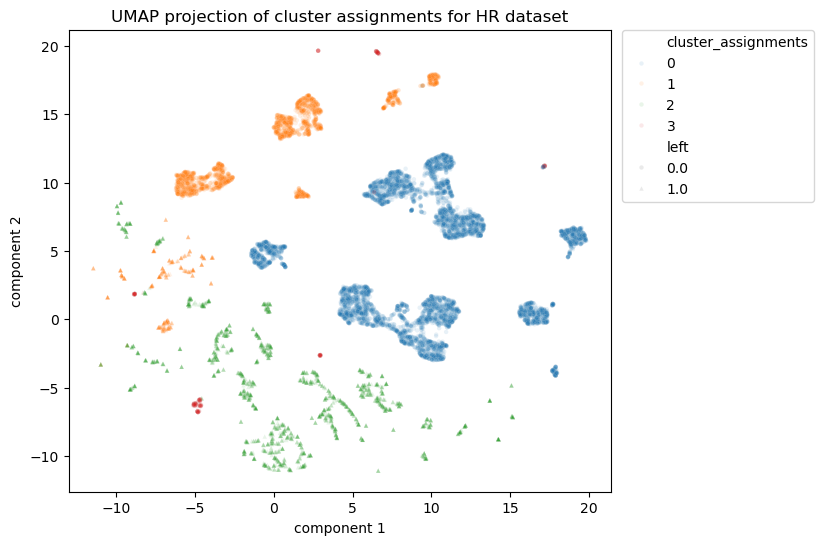

In [121]:
#plot_cluster_assignments(HR_data)
plot_cluster_assignments(HR_embedding_df, HR_data['cluster_assignments'])

The records assigned to the cluster with the employees who left the company fall in several groups on the graphs. While it is good most of these records are in one cluster, interpreting the characteristics of these employees in a meaningful way will be difficult at best.      

### Evaluating number of clusters

Given the foregoing results it seems entirely possible that the a different number of clusters might provide better insight into to structure of the data. But how can we evaluate the clusters? With **non-Euclidean** we cannot use the WCSS. We need alternatives. There are several possibilities     

A simple metric is **Maximum diameter of clusters**. As more clusters are used in a model the clusters become smaller. But, as the model becomes complex, the reduction in the size of the clusters diminishes. The distance must be measured using the clustering distance metric, which can be non-Euclidean. The maximum diameter of cluster, $C_i$, is:  

$$diameter(C_i) = max_{j,k \in C_i} d(x_j,x_k)$$    

In addition to maximum cluster diameter, the silhouette coefficent is a useful metric for non-Euclidean distance metrics.

> **Exercise 7-4:** 
> You will compltete the code in the cell below so that it performs the following operations:    
> 1. The `evaluate_agglomerative_clusters` function Iterate over each cluster and performs the following operations.    
>  - Deleate any prevcious cluster assignment column.   
>  - Create a new temporary model.  
>  - Cluster assignments are made with the predict method.  
>  - Compute the silhouette coefficient with the `silhouette_score` function and append the result to the `silhouette_coefficients` list.   
>  - The `find_max_diameter` function is called and the value is appended to the `max_diameters` list. 
> 2. The `find_max_diameter`function iterates over all cluster assignments doing the following: 
>   - Create a temporary data frame containing only samples assigned to the particular cluster (ith cluster), make sure to drop the `cluster_assignments` column. 
>   - Using the temporary data frame ompute the maximum diameter and append it to the 'max_diameters' list. Use the [sklearn.metrics.pairwise_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html) function and the [numpy.amax](https://numpy.org/doc/stable/reference/generated/numpy.amax.html) function. 
>   - The maximum of the maximum is returned.      
> 3. Plots the maximum of the diameter of the clusters for each value of $k$.   
> Execute the code and examine the results. Since hierarchical clustering is computationally intensive, execution of this code may take some time.  

,NumberClusters,ClusterDiameter,SilhouetteCoefficient
0,4,6.392194,0.334450
1,5,6.345989,0.316456
2,6,6.159535,0.309247
3,7,5.880169,0.329399
4,8,5.723980,0.331453
5,9,5.239012,0.350586
6,10,5.198759,0.343410
7,11,4.983349,0.346992
8,12,4.941374,0.376237
9,13,4.723220,0.368739


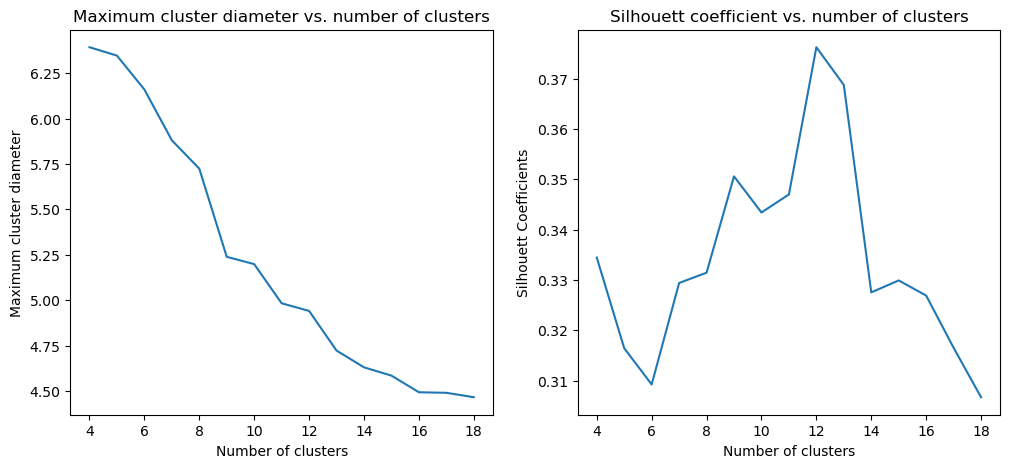

In [122]:
def find_max_diameter(df, metric='manhattan'):
    max_diameters = []
    ## Put your code below
    for i in df.loc[:,'cluster_assignments'].unique():
        temp = df[df.loc[:,'cluster_assignments']==i].drop(columns='cluster_assignments')
        max_diameters.append(np.amax(pairwise_distances(temp, metric=metric)))  
    return np.amax(max_diameters) 

def evaluate_agglomerative_clusters(df, metric='manhattan', linkage='complete', nclusts=(4,18)): 
    silhouette_coefficients = []
    max_diameters = []
    for k in range(nclusts[0],nclusts[1]+1):
        ## Put your code below
        ## First compute the cluster assignmenets for the number of clusters, k
        if 'cluster_assignments' in df.columns: df.drop(columns='cluster_assignments', inplace=True)
        temp_mod=AgglomerativeClustering(n_clusters=k, linkage='complete', metric=metric, 
                                         compute_full_tree=False)
        cluster_assignments = temp_mod.fit_predict(df)    
        
        ## Compute and append the silhouette coefficeint to the list 
        silhouette_coefficients.append(silhouette_score(df, cluster_assignments, metric=metric))
        
        ## Find the max diameter of the clusters
        ## First add the cluster assignment column to the data frame
        df['cluster_assignments'] = cluster_assignments    
        max_diameters.append(find_max_diameter(df, metric=metric))

    ## Plot the results     
    _, ax = plt.subplots(1,2, figsize=(12,5))    
    ax[0].plot(range(nclusts[0],nclusts[1]+1), max_diameters);
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('Maximum cluster diameter')
    ax[0].set_title('Maximum cluster diameter vs. number of clusters')
    ax[1].plot(range(nclusts[0],nclusts[1]+1), silhouette_coefficients);
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouett Coefficients')
    ax[1].set_title('Silhouett coefficient vs. number of clusters')
    return pd.DataFrame({'NumberClusters':range(nclusts[0],nclusts[1]+1),
                         'ClusterDiameter':max_diameters ,
                         'SilhouetteCoefficient':silhouette_coefficients})  

evaluate_agglomerative_clusters(HR_data)    

> Examine the plot. These curves are not smooth. The silhoette coefficient peaks at 12 clusters. The maximum cluster diameter is still monotonically decreasing at 12 clusters with a possible break in slope at 13 clusters. These observations mean that the trade-off between compact clusters and cluster separation is approximately optimal at 13 clusters.     
>
> Next, in the cell below create and execute code to do the following:   
> 4. Delete the cluster assignment column if one is present.   
> 5. Compute the 13 cluster model with complete linkage and the Manhattan distance metric, using the `fit_predict` method, and assign the clusters from the model. Prefix the line of code calling the `fit` method with the `%time` directive.     
> 6. Display a frequency table of the `left` variable by cluster assignment.  

In [123]:
nr.seed(2323)
## Put your code below
n_clusters=13
if 'cluster_assignments' in HR_data.columns: HR_data.drop(columns='cluster_assignments', inplace=True)
model_agglomerative =  AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', 
                                               metric='manhattan', compute_full_tree=False)   
%time HR_data['cluster_assignments'] = model_agglomerative.fit_predict(HR_data)
HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)

CPU times: user 2.53 s, sys: 112 ms, total: 2.65 s
Wall time: 2.34 s


cluster_assignments  left
0                    0.0     2517
1                    0.0      514
2                    0.0      228
3                    0.0       55
                     1.0        1
4                    0.0     6683
5                    1.0      497
6                    1.0     1081
7                    0.0       64
8                    1.0     1268
9                    0.0     1350
10                   1.0       94
11                   1.0      630
12                   0.0       17
Name: count, dtype: int64

> Answer the following questions.   
> 1. Are the majority of the records of employees who left the company in clusters without employees who did not leave the company?   
> 2. Given the foregoing observation does this model appear to identify some structure in the data which might provide insight into employees leaving the company and what is it?    


> **Answers:** 
> 1.  Yes, the majority of records of employees who left the company are in clusters (5, 6, 8, 10, 11) that do not have employees who did not leave the company. This suggests a clear separation of employees who left versus those who stayed.

> 2.  The model seems to have successfully identified clusters that predominantly separate employees who left from those who did not. This clear separation indicates that there are distinct patterns in the features used that differentiate employees who leave from those who stay, from the above we can see that those that left are in relatively smaller clusters. It also suggests that certain groups of employees (based on features used in clustering) are more prone to leaving the company.

> To further evaluate this model, create and execute the code in the cell below to UMAP plot and examine the results.    

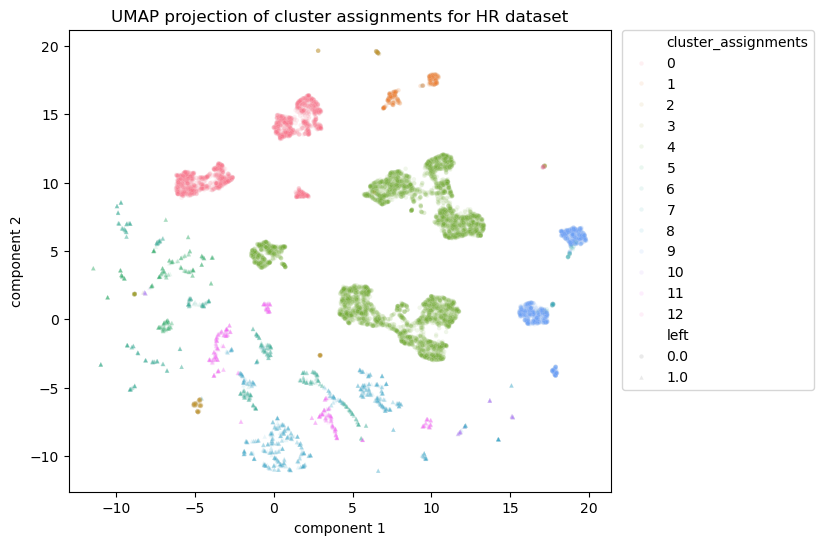

In [124]:
plot_cluster_assignments(HR_embedding_df, HR_data['cluster_assignments'])

> 3. Examine this plot displaying 13 clusters. Are the clusters containing the employees leaving displayed in the plots in tight (small) clusters and well separated clusters?     

> **Answer:** Yes, they are now fairly tight and more well separated than before. However, relative to the employees staying the clusters are still not as tight.          

> Next, create and execute the violin plot code in the cell below to further explore the relationships in the clusters. Do this for satisfaction level, number of projects, and average monthly hours by cluster assignment.

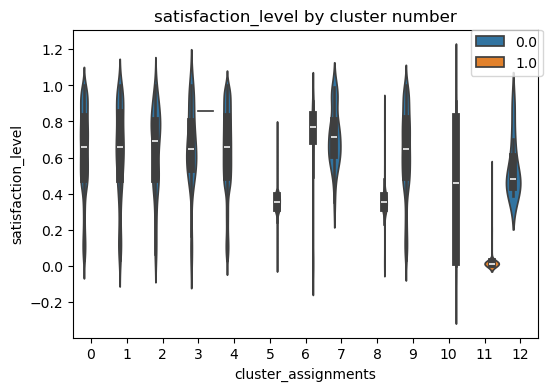

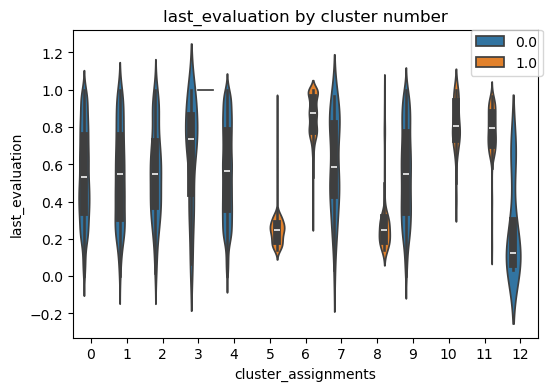

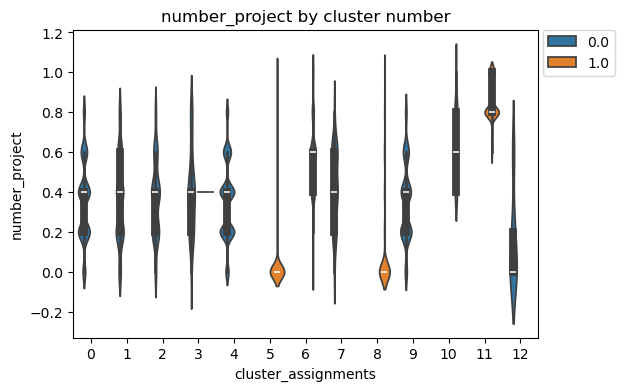

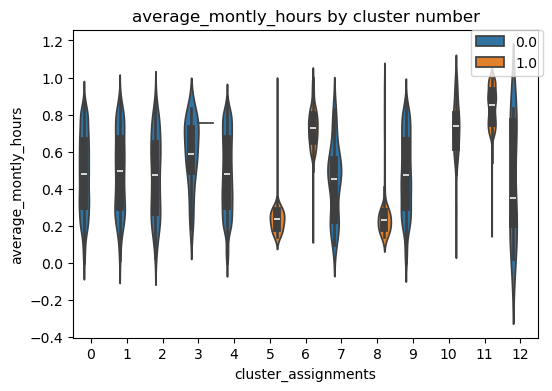

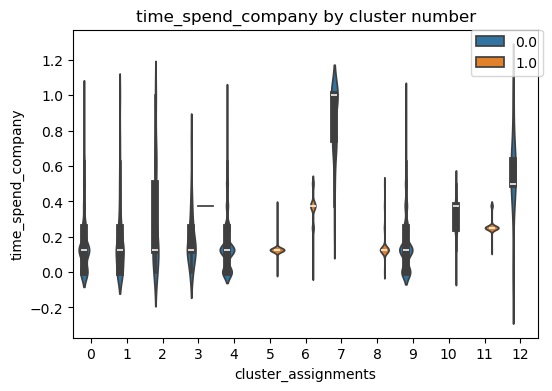

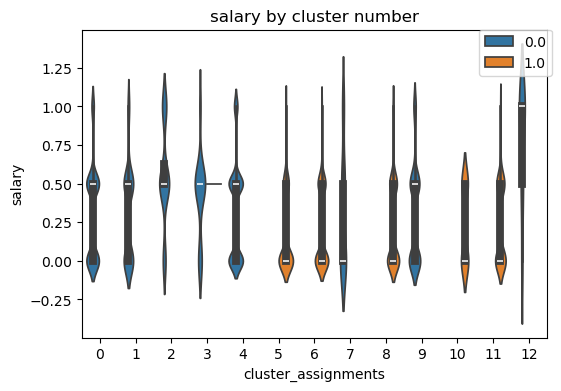

In [125]:
## Put your code below
for factor in plot_columns:
    plot_clusters_by_factor(HR_data, factor=factor)   

> These results look similar to the those from the 8 cluster k-means algorithm. However, in detail there are some differences representing the different algorithms used. Examine these plots carefully and answer these questions:    
> 4. Is there evidence that employees with low satisfaction are likely to leave the company?      
> 5. Is there evidence that employees with high and low numbers of projects and average monthly hours worked are likely to leave the company?       
> **End of exercise.**

> **Answers:**     

> 4. There is some evidence that employees with low satisfaction are likely to leave the company. However the contrary can also be seen in cluster 6, which has high satisfaction but consists of employees who left the company.    

> 5. Yes, looking at the violin charts, it is still the employees with extremes of high/low number of projects and average monthly hours that are most likely to leave the company.     

## K-Mediods Clustering with CLARA  

**K-mediods** algorithms extend the general ideas of k-means to non-Euclidean spaces. The k-means algorithm specifically requires the ability to complete a centroid or multi-variate mean for each clusters. Since, the multi-variate mean is only defined in Eucledian spaces, it is impossible to extend k-means algorithms to non-Eucledian spaces. The k-metriods algorithms overcome this difficulty by using mediods as cluster centers. In simple terms, a mediod is a sample that serves as the ceneter of a cluster. 

A mediod of cluster $C_i$, $s_m$ is the sample that minimizes the sum of the distance metric, or **deviation**, $d(s_m,s_j)$ to all other samples in the cluster $s_{j \in C_i, j \ne m}$:

$$s_m = \underset{\mathrm{m \in C_i}}{argmin} \big[ \sum_{j \in C_i, j \ne m} d(s_m,s_j) \big]$$   

The $k$ metriods are selected to minimize the **total deviation (TD)**. 

$$TD = \sum_{i=1}^k \sum_{j \in C_i, j \ne m} d(s_j,s_{m,i})$$

Unfortunately, there is no direct solution for this [**NP hard**](https://en.wikipedia.org/wiki/NP-hardness#:~:text=In%20computational%20complexity%20theory%2C%20NP,is%20the%20subset%20sum%20problem.) optimization problem. There are no known polynomial time algorithms for such problems. A brute-force approach of enumerating all possible [combinations](https://en.wikipedia.org/wiki/Combination) is feasible for only very small numbers of samples. Therefor, we must rely on a good **heuristic** to find an approximate solution. Because of its importance in unsuppervised learning there has been considerable research into find accurate and fast heuristic algorithms for the k-metriod problem. It is important to keep in mind that all such heuristic solutions are an approximation at best.   

There are two different approaches that are widely used. The original **partioning around mediods or PAM** algorithm of [Kaufman and Rousseeuw, 1990](https://www.scirp.org/(S(czeh2tfqyw2orz553k1w0r45))/reference/ReferencesPapers.aspx?ReferenceID=1771062) uses two steps:   
1. The BUILD step finds the $k$ initial metriods. A first mediod is found by globally minimizing the deviation on a single mediod. The additional $k-1$ metriods are then found sequentially by minimizing TD for each addition. This algorithm is greedy, as it reduces TD by the maximum at each step. However, there is no guarantee that TD is minimized globally.     
2. The SWAP or exchange step then tests other samples as potential mediods. Each of the samples becomes a candidate mediod, and TD is computed. If this exchange of mediods reduces TD the new metriod assigment is retained. The SWAP steps are repeated until no significant improvement in TD is found. Once again, this is a greedy algorithm with no guarantee of finding the globally optimal solution.      

The PAM algorithm can be effective, but has poor scalability with complexity of $O(n^2k)$ once caching of intermediate results is employed in the SWAP step. As a result of the poor scalability, there is ongoing research into more efficient k-metriods algorithms. A recent review of this work can be found in [Schubert and Rousseuw, 2021](https://www.sciencedirect.com/science/article/pii/S0306437921000557?ref=pdf_download&fr=RR-2&rr=7ce03f30a8332f02). 

The **Custering LARge Applications (CLARA)** algorithm is a mini-batch variation on PAM. CLARA typically uses a randomly (Brenoulli) sampled mini-batch of size $n'=40+2k$. CLARA has compuational efficience of approximately $O(k^3 + n)$. Thus, CLARA is scalable to large numbers of samples, $n$, as long as the number of required clusters, $k$, is fairly small. Further, variations of CLARA allow the independent samples be processed in parallel.       

,NumberClusters,ClusterDiameter,SilhouetteCoefficient
0,3,7.668317,0.260503
1,4,6.917505,0.297773
2,5,6.546970,0.335283
3,6,6.546970,0.275066
4,7,6.388374,0.240166
5,8,6.394903,0.261080
6,9,5.631682,0.258525
7,10,5.857621,0.211425
8,11,6.388374,0.229770
9,12,5.857621,0.236316


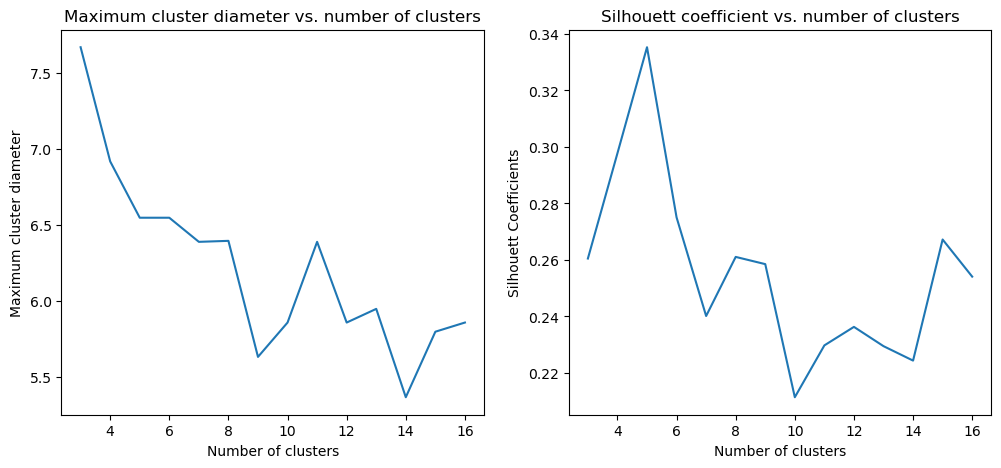

In [126]:
def evaluate_CLARA(df, metric='manhattan', linkage='complete', nclusts=(3,16)): 
    silhouette_coefficients = []
    max_diameters = []
    for k in range(nclusts[0],nclusts[1]+1):
        ## Put your code below
        ## First compute the cluster assignmenets for the number of clusters, k
        if 'cluster_assignments' in df.columns: df.drop(columns='cluster_assignments', inplace=True)
        temp_mod=CLARA(n_clusters=k, metric=metric)
        cluster_assignments = temp_mod.fit_predict(df)    
        
        ## Compute and append the silhouette coefficeint to the list 
        silhouette_coefficients.append(silhouette_score(df, cluster_assignments, metric=metric))
        
        ## Find the max diameter of the clusters
        ## First add the cluster assignment column to the data frame
        df['cluster_assignments'] = cluster_assignments    
        max_diameters.append(find_max_diameter(df, metric=metric))

    ## Plot the results     
    _, ax = plt.subplots(1,2, figsize=(12,5))    
    ax[0].plot(range(nclusts[0],nclusts[1]+1), max_diameters);
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('Maximum cluster diameter')
    ax[0].set_title('Maximum cluster diameter vs. number of clusters')
    ax[1].plot(range(nclusts[0],nclusts[1]+1), silhouette_coefficients);
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouett Coefficients')
    ax[1].set_title('Silhouett coefficient vs. number of clusters')
    return pd.DataFrame({'NumberClusters':range(nclusts[0],nclusts[1]+1),
                         'ClusterDiameter':max_diameters ,
                         'SilhouetteCoefficient':silhouette_coefficients})  

evaluate_CLARA(HR_data)    

> **Exercise: 7-5** Now, you will apply the CLARA algorithm to the HR dataset by the following steps:  
> 1. Make sure there is not a `cluster_assignments` column in the HR_data data frame, using an `if` statement.  
> 2. Compute the cluster assignements using the [sklearn_extra.cluster.CLARA](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.CLARA.html) function, with arguments `n_clusters=5`, `metric='manhattan'`, and `random_state=4477`. Prefix your call to CLARA with the `%time` IPython magic statement. 
> 3. Assign the `labels_` attribut of the CLARA model object to the `cluster_assignments` column in the HR_data data frame. 
> 4. Compute and display the frequency table of the cluster assignemnts by the `left` variable. 

In [127]:
# Ensure there is no cluster_assignments column in the HR_data DataFrame
if 'cluster_assignments' in HR_data.columns:
    HR_data.drop(columns='cluster_assignments', inplace=True)

# Apply the CLARA algorithm with the specified parameters
clara_model = CLARA(n_clusters=5, metric='manhattan',random_state=4477)
%time cluster_assignments = clara_model.fit_predict(HR_data)

# Assign the labels_ attribute to the cluster_assignments column in the HR_data DataFrame
HR_data['cluster_assignments'] = cluster_assignments

HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)

CPU times: user 13.7 ms, sys: 59 μs, total: 13.8 ms
Wall time: 7.04 ms


cluster_assignments  left
0                    0.0       42
                     1.0      628
1                    0.0      155
                     1.0     1176
2                    0.0     8107
                     1.0       69
3                    0.0       42
                     1.0     1631
4                    0.0     3082
                     1.0       67
Name: count, dtype: int64

> Next, execute the code in the cell below to display the UMAP prjection of the cluster assignments.  

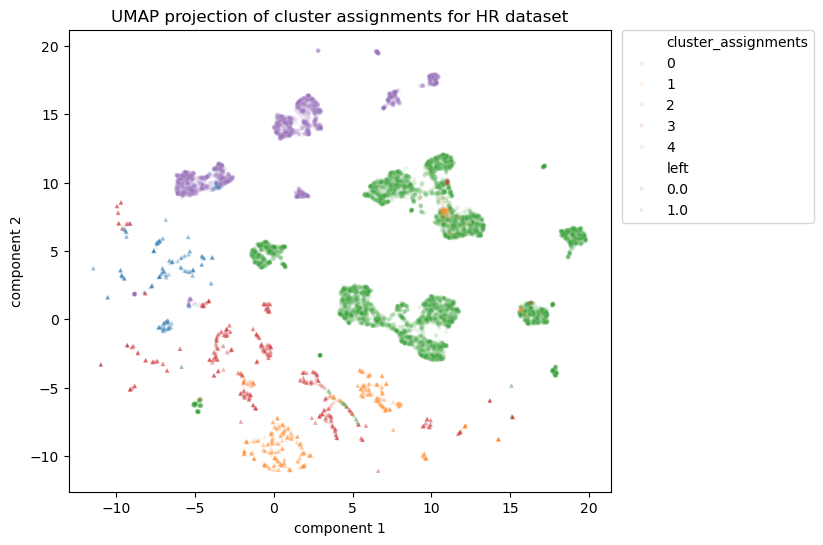

In [128]:
#Plot the cluster assignments
plot_cluster_assignments(HR_embedding_df, HR_data['cluster_assignments'])

> Examine the results of the frequency table and the UMAP projection and answer the following questions:     
> 1. Are the clusters created with the CLARA algorithm well compact and well separated, or do you see evidence of fragmentation of the clusters? If so, what is your evidence?     
> 2. Given that CLARA is based on an approximate heuristic is the result you describe in your answer to the previous question expected and why?     
> 3. Comapare the cluster assignements found with CLARA to the assignments discovered with aglommerative clustering also using the Manhattan distance metric. Keep in mind that both algorithms employ a greedy heuristic. Why do you think these solutions differ?    
> 4. Comapare the run time of the CLARA to the assignments discovered with aglommerative clustering also using the Manhattan distance metric. From this observation, what can you say about the trade-off between accuacy and run time for these algorithms?    

> **Answers:**
> 1. Somehwat more fragmentation. We can see from the outputs that each cluster now has both left = 0 and 1, also the evidence in the plot shows mixing of the cluster colors, especially in the bottom left.
> 2. Yes, the result described is expected because CLARA is based on an approximate heuristic that uses random sampling to find an approximate solution to the k-medoid problem, which can result in suboptimal clustering compared to exact algorithms.The tradeoff should be precision (hence fragmentation) for scalability and efficiency.
> 3. They are similar, and both use the Manhattan distance metric, but the way the algorithms handle the distances and clustering process can lead to different outcomes. Specifically,  The random sampling in CLARA introduces variability in the cluster assignments, whereas agglomerative clustering has a deterministic process (given a fixed linkage and distance metric).   
> 4. The run time is much faster for CLARA as it is using approximations in exchange for efficiency, and so is less accurate compared to aglommerative clustering.    

## Clustering with Sparse Graphs

We have already used the agglomerative clutering algorithm that build a **tree**, a graph with no cycles. The members of the clusters are defined by cutting the tree at a selected level. 

The UMAP algorithm is based on some very sophistical graph theory. We will examine some of the details in another lesson.   

We will now look at some other graph-based clustering methods. First we wil work with the **spectral clustering** algorithm. Then we turn our attention to class of scalable and flexible clustering algorithms including **DBSCAN** and **OPTICS**.   

We start by examining some basic concepts of how graphs are constructed from feature values. The basic idea is to find near-neighbors using some distance metric. The near-neighbors are connected with edges to form the graph. The edge weights are the distances between the near-neighbors. Many algorthms for these tasks have been created. The differences are generally in the way near-neighbors are defined.  

Since these edges of these graphs only connect the nearest neighbors the resulting representation is inherently **sparse**. In other words, the association matrix is represented in a sparse manner. Using a sparse representation reduces the required memory and computation compared to using a dense distance matrix.      

For the examples shown here, we will apply two simple methods of near-neighbor detection to the same dataset:     
1. Using a fixed radius in the high-dimensional space to find near-neighbors to connect with graph edges. This method is ituitively attractive. Nearest-neighbors must be within some radii in the distance metric. However, using a fixed radius prevents this method from adapting to the expected variations of density in the high-dimensional space.     
2. Using a fixed number of near neighbors in the high dimensional space to determine which nodes to connect with edges. Again, this method makes intuative sense. However, with variable density in the high-dimensional space the distances between near neighbors can be quite variable.   

For these examples of graph construction we will use the well-worn iris dataset. To load these data and display a sample, execute the code in the cell below.    

In [129]:
iris_data = load_iris()

## Normalize the data values  
temp = (iris_data['data'] - iris_data['data'].mean(axis=0)) / iris_data['data'].std(axis=0)

## Prepare the data frame 
target_species = {0:'Setosa',1:'Versicolour',2:'Virginica'}
species = [target_species[x] for x in iris_data['target']]
iris = pd.DataFrame(temp, columns=['sepal_length','sepal_width','petal_length','petal_width'])
iris['species'] = species
iris_data = temp
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,-0.900681,1.019004,-1.340227,-1.315444,Setosa
1,-1.143017,-0.131979,-1.340227,-1.315444,Setosa
2,-1.385353,0.328414,-1.397064,-1.315444,Setosa
3,-1.506521,0.098217,-1.283389,-1.315444,Setosa
4,-1.021849,1.249201,-1.340227,-1.315444,Setosa
...,...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832,Virginica
146,0.553333,-1.282963,0.705921,0.922303,Virginica
147,0.795669,-0.131979,0.819596,1.053935,Virginica
148,0.432165,0.788808,0.933271,1.448832,Virginica


### Graph construction by radius    

The code in the cell below computes and displays nearest neighbor graphs using the constant radius algorithm implemented with the [sklearn.neighbors.radius_neighbors_graph](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.radius_neighbors_graph.html) function. Graphs are constructed for 4 different radii. The graphs are converted to NetworkX format and then displayed. Execute this code and examine how the connectivity changes with the nearest neighbor radii.        

For radius = 2.0.  Dense size = 11250.0


<150x150 sparse matrix of type '<class 'numpy.float64'>'
	with 9104 stored elements in Compressed Sparse Row format>

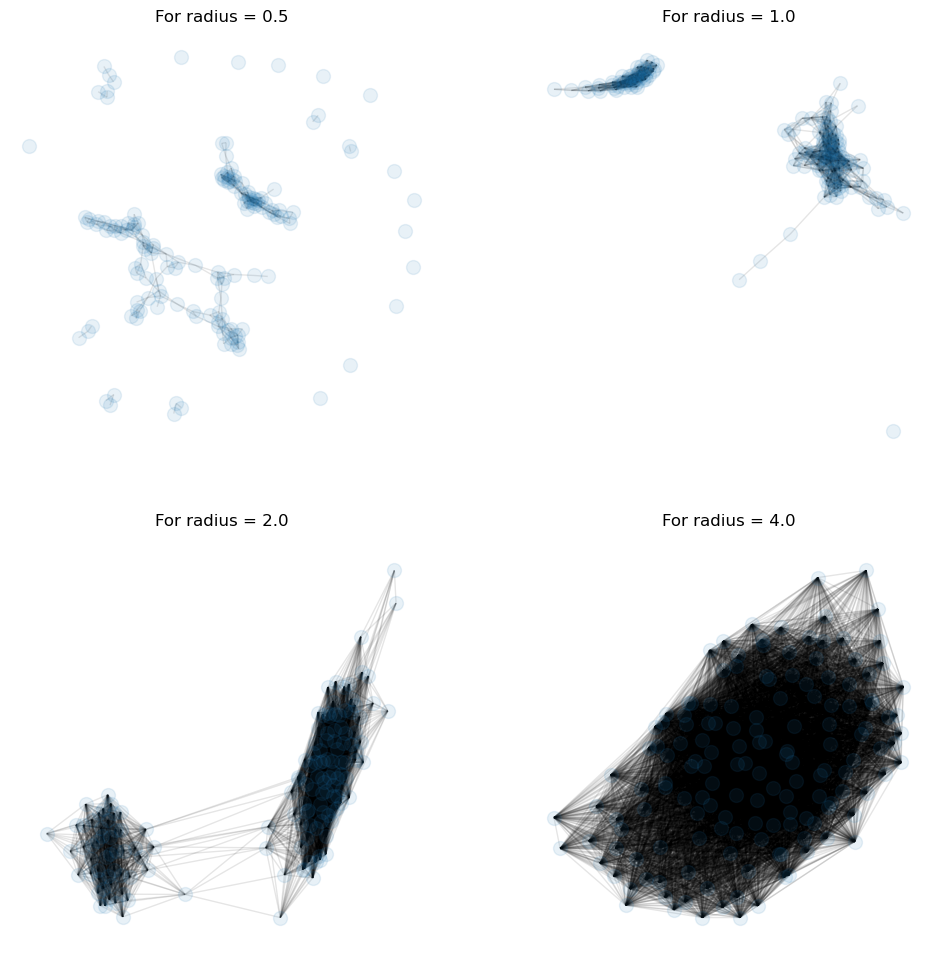

In [130]:
_,ax = plt.subplots(2,2, figsize=(12,12))
ax=ax.flatten()
for i,rad in enumerate([0.5, 1.0, 2.0, 4.0]):
    iris_graph = radius_neighbors_graph(iris_data, radius=rad)
    nx.draw(nx.from_numpy_array(iris_graph), alpha=0.1, node_size=100, ax=ax[i]);
    ax[i].set_title('For radius = ' + str(rad))

dense_size = 0.5 * iris_data.shape[0]*iris_data.shape[0]    
print('For radius = 2.0.  Dense size = ' + str(dense_size))
radius_neighbors_graph(iris_data, radius=2.0)

> **Exercise 7-6** Now, answer the following questions:    
> 1. For the graphs created with radii of 0.5 and 1.0, what problem can you see with these graphs that would prevent the application of a cluster model.        
> 2.  For the graph created with radius of 4.0 what problem can yousee that would prevent a reasonable cluster model from being computed?     
> 3. What is the approximate compression of the sparse graph representation, with radius of 2.0, compared to the dense upper triangular matrix?  
> **End of Exercise.**

> **Answers:**

> 1. 

>0.5 Radius - Insufficient Connectivity: The graph is likely very sparse, with many isolated nodes or very small disconnected subgraphs. This lack of connectivity can make it difficult to identify meaningful clusters, as the graph may not contain enough edges to form well-defined clusters.    

> 1.0 Radius - Limited Connectivity: Although there will be more connections than with a radius of 0.5, the graph may still have many nodes with few connections and two separate communities. This can lead to clusters that are either too small or too numerous, making it challenging to identify a few meaningful clusters.

> 2. Over-Connectivity: With a large radius like 4.0, the graph becomes highly connected, potentially forming one large, dense cluster or a few very large clusters. This over-connectivity can mask the underlying structure of the data, making it difficult to discern distinct clusters. 

> 3. Given 9104 elements, vs 11250 for the dense upper triangular matrix, the ratio is approximately 81% for graph with radius of 2.0 to the size of the dense upper triangular matrix, achieving about 19% compression, reducing memory usage and computational complexity.

### Graph construction by nearest neighbors     

The code in the cell below computes and displays nearest neighbor graphs using the k-neighbor algorithm implemented with the [sklearn.neighbors.kneighbors_graph](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html) function. The graphs are constructed for 4 different number of neighbors. Graphs are converted to NetworkX format and then displayed. Execute this code and examine how the connectivity changes with the number of nearest neighbors. 

  (0, 17)	1.0
  (0, 27)	1.0
  (0, 40)	1.0
  (0, 39)	1.0
  (0, 4)	1.0
  (1, 25)	1.0
  (1, 45)	1.0
  (1, 12)	1.0
  (1, 34)	1.0
  (1, 9)	1.0
  (2, 47)	1.0
  (2, 29)	1.0
  (2, 3)	1.0
  (2, 30)	1.0
  (2, 34)	1.0
  (3, 47)	1.0
  (3, 30)	1.0
  (3, 29)	1.0
  (3, 2)	1.0
  (3, 42)	1.0
  (4, 37)	1.0
  (4, 0)	1.0
  (4, 40)	1.0
  (4, 17)	1.0
  (4, 27)	1.0
  :	:
  (145, 112)	1.0
  (145, 141)	1.0
  (145, 140)	1.0
  (145, 104)	1.0
  (145, 139)	1.0
  (146, 123)	1.0
  (146, 111)	1.0
  (146, 72)	1.0
  (146, 108)	1.0
  (146, 83)	1.0
  (147, 116)	1.0
  (147, 137)	1.0
  (147, 112)	1.0
  (147, 104)	1.0
  (147, 145)	1.0
  (148, 136)	1.0
  (148, 100)	1.0
  (148, 115)	1.0
  (148, 124)	1.0
  (148, 144)	1.0
  (149, 138)	1.0
  (149, 127)	1.0
  (149, 70)	1.0
  (149, 78)	1.0
  (149, 103)	1.0
  (0, 17)	1.0
  (0, 27)	1.0
  (0, 40)	1.0
  (0, 39)	1.0
  (0, 4)	1.0
  (0, 28)	1.0
  (0, 7)	1.0
  (0, 37)	1.0
  (0, 26)	1.0
  (0, 11)	1.0
  (1, 25)	1.0
  (1, 45)	1.0
  (1, 12)	1.0
  (1, 34)	1.0
  (1, 9)	1.0
  (1, 30)	1.0
  (1, 3

<150x150 sparse matrix of type '<class 'numpy.float64'>'
	with 3000 stored elements in Compressed Sparse Row format>

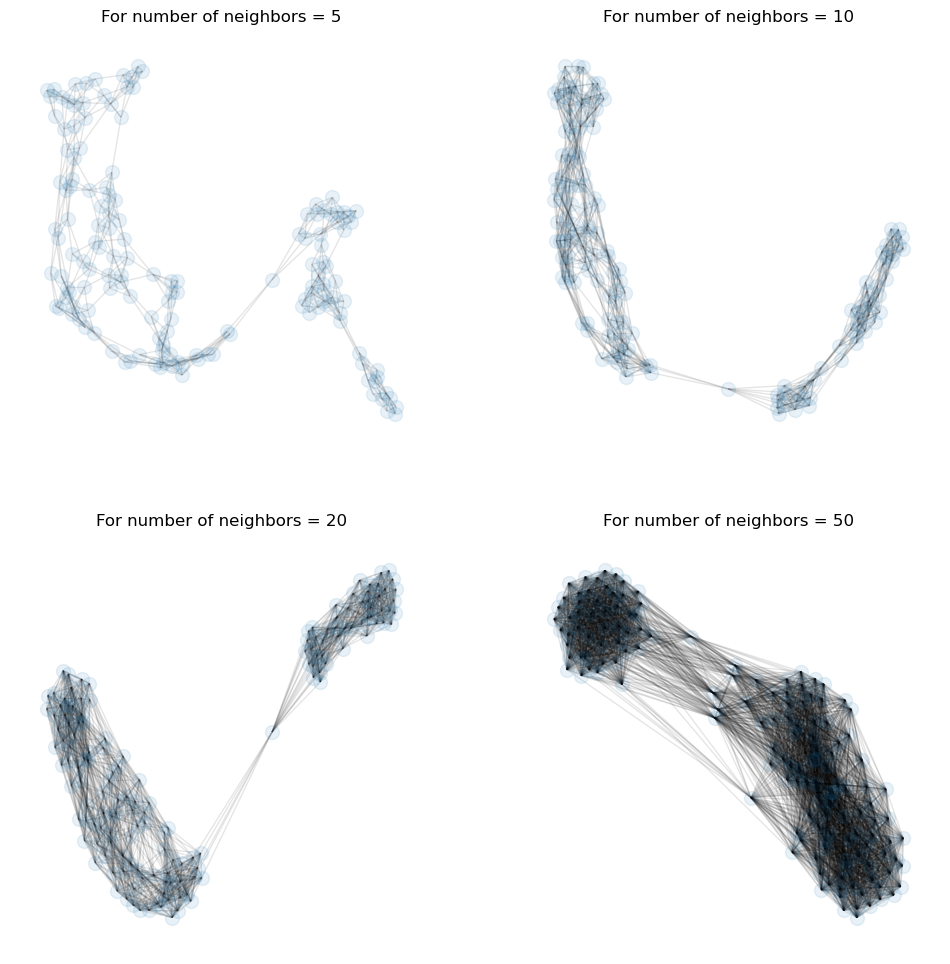

In [131]:
_,ax = plt.subplots(2,2, figsize=(12,12))
ax=ax.flatten()
for i,k in enumerate([5, 10, 20, 50]):
    iris_graph = kneighbors_graph(iris_data, n_neighbors=k)
    print(iris_graph)
    nx.draw(nx.from_numpy_array(iris_graph), alpha=0.1, node_size=100, ax=ax[i]);
    ax[i].set_title('For number of neighbors = ' + str(k))
print('For k = 20.  Dense size = ' + str(dense_size))
kneighbors_graph(iris_data, n_neighbors=20)

> **Exercise 7-7:** Now, answer the following questions:    
> 1. For the graphs created by the k nearnest neighbot algorithm, what unusual aspect of the connectivity can you see and what effect might this have on the clusters computed from these graphs.          
> 2. What is the approximate compression of the sparse graph representation, with k=20, compared to the dense upper triangular matrix?  
> 3. Compare the graphs created with the radius algorithm with those using the nearest neighbors algorithm. Which graphs do you think will be better in terms of finding good clusters and why?     
> **End of Exercise.**

> **Answers:**
> 1. Uniform Connectivity: The k-nearest neighbor algorithm ensures that each node has exactly k connections. This uniformity can lead to artificial clusters where nodes are connected to the same number of neighbors regardless of the underlying data density. This can also introduce cycles, which might not represent the true clustering structure of the data.    
> 2. Number of stored elements would be 20 * 150 = 3000, compared with 11250 the ratio is approx 27%, indicating a 73% compression.  
> 3. The radius algorithm is likely better at finding good clusters because it can adapt to the natural density of the data. Clusters formed by the radius method are more likely to be well-separated and compact, representing the true structure of the dataset. Whereas k nearest neighbours is easier to implement and parameterize, but might not capture the true clustering structure in datasets with variable density, leading to less accurate clusters.
   

## Spectral Clustering   

Spectral clustering is a graph-based clustering algorithm. In summary, the algorithm uses the following steps:  

1. Create an undirected graph of the data samples. This graph can be fully connected or use only nearest-neighbors. The edge weights are the similarity between the samples. An association matrix is created from this graph.  
2. The graph Laplacian matrix is computed. 
2. An eigen-decomposition of the graph Laplacian is performed. The k eigenvectors corresponding to the smallest nonzero eigenvalues define the **spectrum** of the graph.   
3. A clustering algorithm is applied to the eigenvectors. Typically, a k-means algorithm is used.  

> **Exercise 07-8:** You will now apply the [sklearn.cluster.SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) to compute a spectral clustering model.  
> 1. Start with the original data encoding (not the cosine similarity encoding) and make sure there is no cluster assignment column.   
> 2. Fit a model using `[sklearn.cluster.SpectralClustering` with the following arguments; `assign_labels='discretize'`, `n_clusters=10`, `affinity='nearest_neighbors'`, `n_neighbors=50`, and `random_state=0`, and using the `fit_predict` method. Prefix your call to `SpectralClustering` with the `%time directive`. 
> 3. Compute and print the frequency table of the cluster assignments.      
> **Note on algorithm:** In this case the spectral clustering algorithm is using nearest neighbor affinity, rather than a fully connected graph. This choice has several consequences. First, the affinity matrix is sparse, making the calculation of the eigenvectors considerably faster, although it may take some time to execute this code as it is. Second, the `SpectralClustering` function may raise a warning that the embedding is an approximation, since the graph is not fully connected.    
> **Note:** Executing this code may take some time. 

In [132]:
nr.seed(7788)

if 'cluster_assignments' in HR_data.columns:
    HR_data.drop(columns='cluster_assignments', inplace=True)

# Applying Spectral Clustering
%time spectral_model = SpectralClustering(assign_labels='discretize', n_clusters=10, affinity='nearest_neighbors', n_neighbors=50, random_state=0)
%time cluster_assignments = spectral_model.fit_predict(HR_data)

HR_data['cluster_assignments'] = cluster_assignments

HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)

CPU times: user 1.09 ms, sys: 388 μs, total: 1.48 ms
Wall time: 252 μs
CPU times: user 1min 1s, sys: 22.2 s, total: 1min 23s
Wall time: 9.05 s


cluster_assignments  left
0                    1.0     1030
1                    0.0     3670
2                    0.0     1149
3                    1.0     1136
4                    0.0     1619
5                    1.0      610
6                    0.0     3013
7                    0.0      609
                     1.0        1
8                    1.0      794
9                    0.0     1368
Name: count, dtype: int64

> Answer the following questions.   
> 1. Are the majority of the records of employees who left the company in clusters without employees who did not leave the company?   
> 2. Given the above, does this model appear to identify some structure in the data which might provide insight into employees leaving the company?    

> **Answers:**     
> 1. Yes, clusters 0,3,5,8 are the only clusters with employees who left and they do not have any employees who did not leave the company, with cluster 7 only having 1 who left.   
> 2. Yes, the clear separation of clusters based on the left variable suggests that the model has identified patterns or features in the data that differentiate employees who are likely to leave from those who are likely to stay, though it is hard to identify fron cluster sizes alone.

> To further evaluate this model, create and execute the code in the cell below to display the UMAP projection plot and examine the results. 

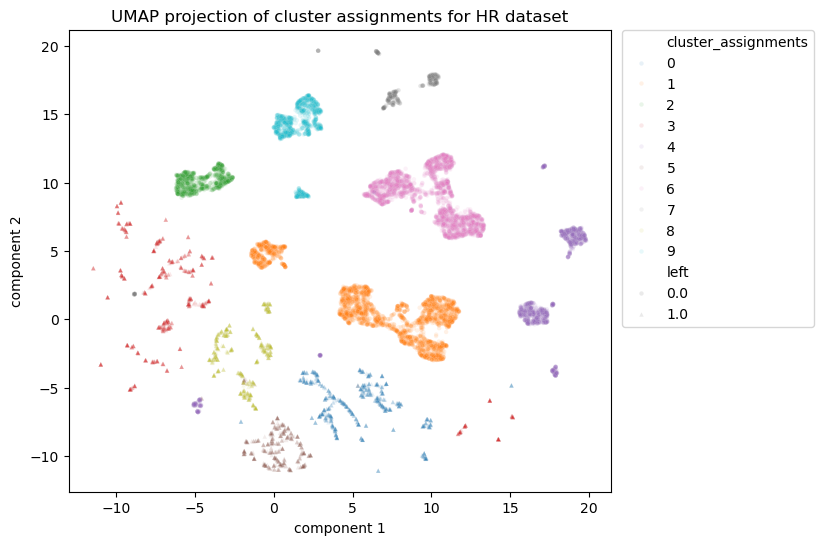

In [133]:
plot_cluster_assignments(HR_embedding_df, HR_data['cluster_assignments'])

> 3. Examine this plot displaying 10 clusters. Are the clusters containing the employees leaving displayed in the plots in tight (small) clusters?     

> **Answer:**   Clusters 0, 3, 5, 8 containing employees who left are all well tight and relatively well separated. 

> Next, create and execute code in the cell below to display violin plots to further explore the relationships in the clusters. Do this for satisfaction level, number of projects, and average monthly hours by cluster assignment.  

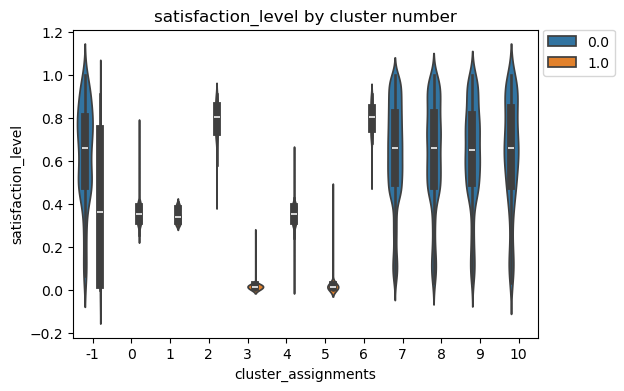

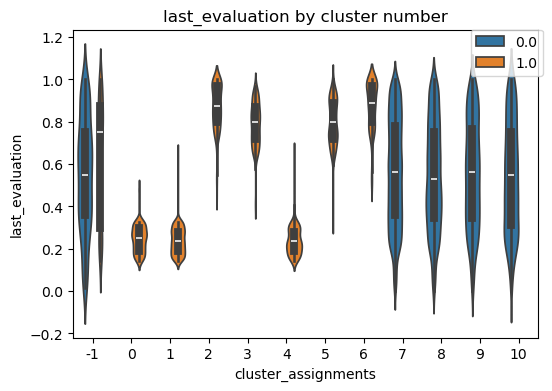

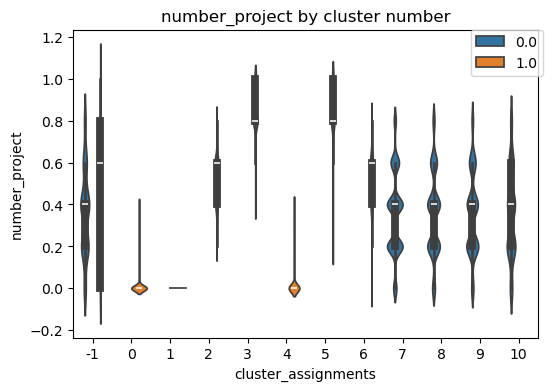

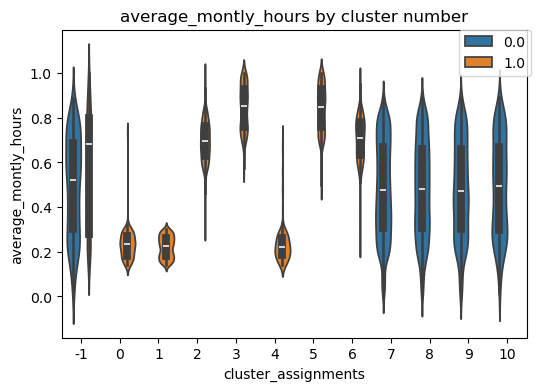

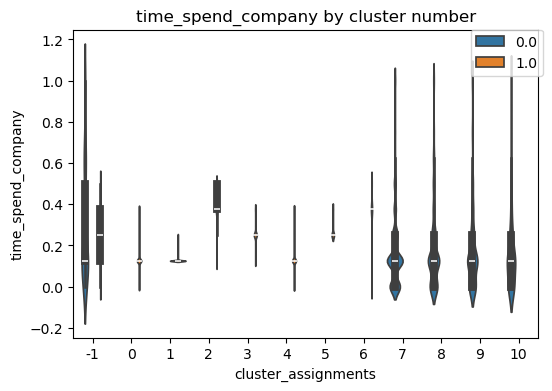

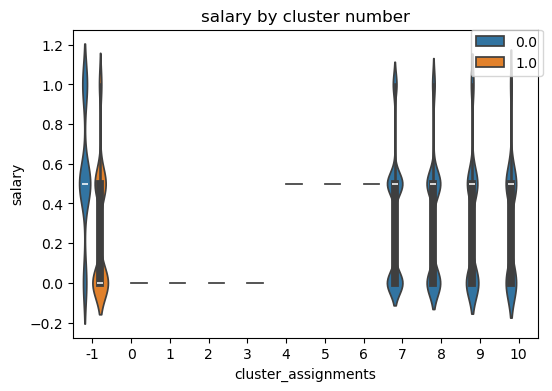

In [141]:
for factor in plot_columns:
    plot_clusters_by_factor(HR_data, factor=factor)

> In detail these results look somewhat different from those from the 8 cluster k-means algorithm. Consequently, one can get a new perspective on the problem of employees leaving the company:   
> 4. What evidence is noticeable in these clusters that employees with low satisfaction are likely to leave the company?      
> 5. What is the evidence that employees with lower numbers of projects are likely to leave the company?        
> 6. What is the evidence that employees with high and low monthly hours worked are likely to leave the company?      
> **End of exercise.**

> **Answers:**     

> 4.  For clusters with employees that left (0,3,5,8) we see the boxplot portion skewed to be lower with violin areas also skewed to be in the lower sections. In contrast, those that stayed all have the violin areas towards the top.

> 5.  This is shown predominantly by cluster 5, with the boxplot and violin at the very bottom of the range. The other clusters with employees leaving show a wider range of project numbers than those that stayed, which also includes very lower number of projects absent in employees that stayed.

> 6.  The boxplots for clusters with employees that left (0,3,5,8) are either wide in range (0,3) or have very high and low monthly work hours (5 and 8). Whereas the clusters for employees that stayed all have fairly temperate hours of hours worked.

## Density Clustering with OPTICS

The OPTICS algorithm is an example of a density clustering algorithm. The algorithm constructs a graph of the data samples. Samples in the dense core of the clusters are connected by undirected edges. Samples on the periphery of the clusters are corrected by directed edges. Samples too far from any cluster are unconnected to any cluster. Unlike the other models you have worked with in this assignment, OPTICS does not require the specification of the number of clusters. The algorithm determines the number of clusters from the number of dense regions found.    

> **Exercise 07-9:** You will now apply the OPTICS algorithm to the HR data set.      
> 1. Make sure there is no cluster assignment column.   
> 2. Fit a model using [sklearn.cluster.OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html) with the following arguments; `p=2`, `min_samples=250`. Use the `fit` method, not fit_predict. Make sure you name your model object `optics_model`. We will use the cluster model object a bit later. Prefix you call to `Optics` with the `%time` directive.    
> 3. Extract the cluster labels from the model object, which are the `.labels_` attribute of the object. 
> 4. Compute and print the frequency table of the cluster assignments.      
> **Note:** Executing this code may take some time. 

In [135]:
nr.seed(4512)

# Remove the 'cluster_assignments' column if it exists
if 'cluster_assignments' in HR_data.columns:
    HR_data.drop(columns='cluster_assignments', inplace=True)

# Fit the OPTICS model
%time optics_model = OPTICS(p=2, min_samples=250)
%time optics_model.fit(HR_data)

# Extract the cluster labels
HR_data['cluster_assignments'] = optics_model.labels_

HR_data['cluster_assignments'] = optics_model.labels_
HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)


CPU times: user 7 μs, sys: 2 μs, total: 9 μs
Wall time: 9.78 μs
CPU times: user 7.26 s, sys: 48.7 ms, total: 7.31 s
Wall time: 7.34 s


cluster_assignments  left
-1                   0.0      302
                     1.0     1050
 0                   1.0      303
 1                   1.0      592
 2                   1.0      348
 3                   1.0      362
 4                   1.0      396
 5                   1.0      265
 6                   1.0      255
 7                   0.0     6683
 8                   0.0     2517
 9                   0.0     1412
 10                  0.0      514
Name: count, dtype: int64

> Answer the following questions.   
> 1. Notice the cluster with label `-1`. These are samples that are too far from any cluster code to be assigned a label. How do you think these unassigned cases affect the interpretation of the model?   
> 2. Are the majority of the records of employees who left the company in clusters without employees who did not leave the company?   
> 3. Given the above, and the number of clusters, does this model appear to identify some structure in the data which might provide insight into employees leaving the company?    

> **Answers:**      
> 1. Label -1 indicates samples that are considered outliers, which suggests that the clusters are well-defined and that the model is strict in assigning points to clusters only if they meet certain density criteria.
> 2. Yes, only the unassigned cluster -1 have both employees who left the company and those who stayed.
> 3. Yes, the OPTICS model appears to effectively identify distinct structures within the data, providing clear clusters that separate employees who left from those who stayed. This separation suggests that there are identifiable patterns and characteristics associated with employee attrition.        

> To further evaluate this model, execute the code in the cell below and examine the resulting embedding display. 

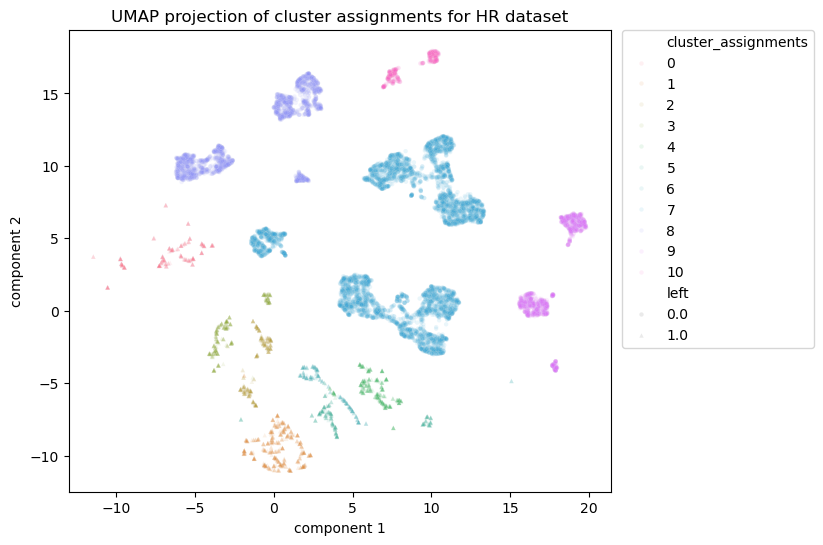

In [136]:
HR_temp = HR_data[HR_data.cluster_assignments > -1]
plot_cluster_assignments(HR_embedding_df, HR_temp['cluster_assignments'])

> 4. Are most of the clusters with employees who left relatively small or compact?      

> **Answer:** 4. Yes, most are relatively small, but not extremely compact when compared to those that stayed.

> To further evaluate this model, execute the code in the cell below and examine the resulting violin plots.  

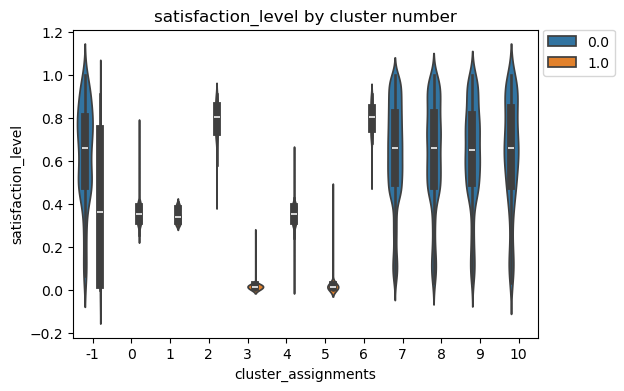

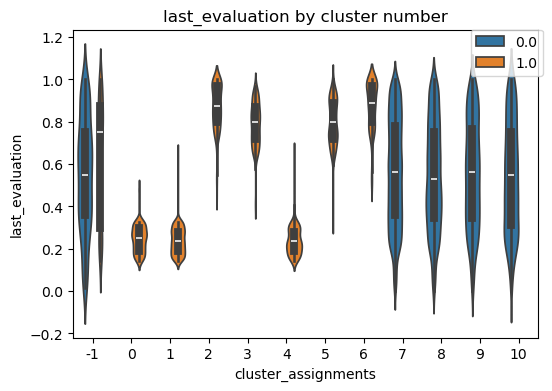

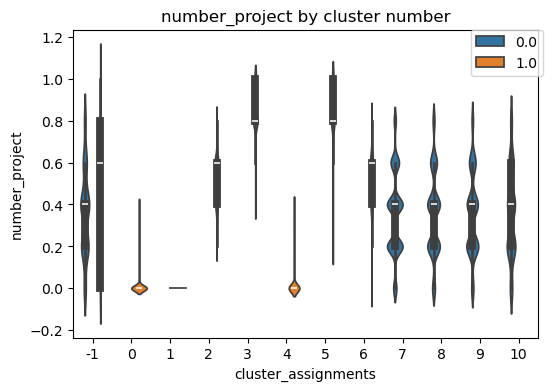

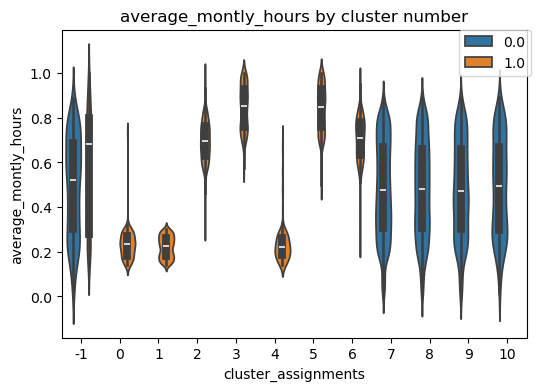

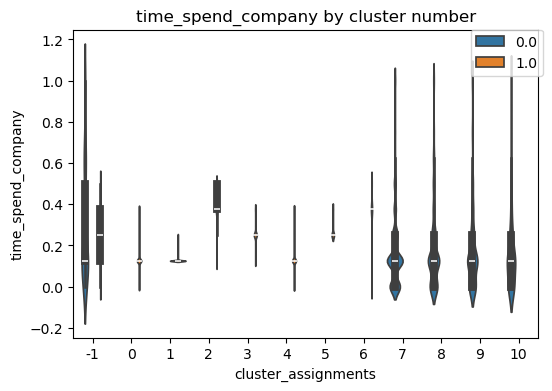

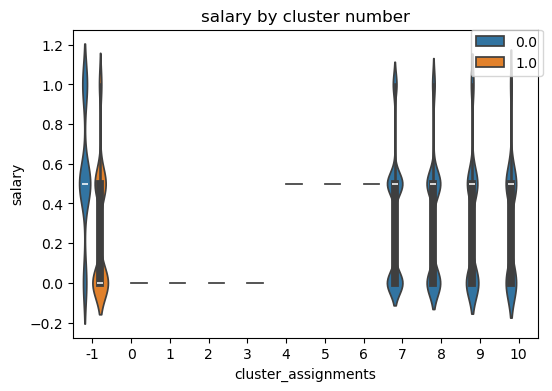

In [142]:
for factor in plot_columns:
    plot_clusters_by_factor(HR_data, factor=factor)   

> 5. Which of these plots show differences in the factor (feature) plotted between the employees who have left and those who have not left. Ignore the unassigned values.               

> **Answer:** 5. All of them show this clearly, with features of clusters 0-6 vs 7-10.

> Finally, let's examine the reachability of the data samples for this density clustering model. The code in the cell below does the following:  
> 1. Extracts the ordered reachability and labels from the model object.    
> 2. Remove the cases where the sample is not a member of any cluster. 
> 3. Plot the reachability, using cluster label as the hue argument. 

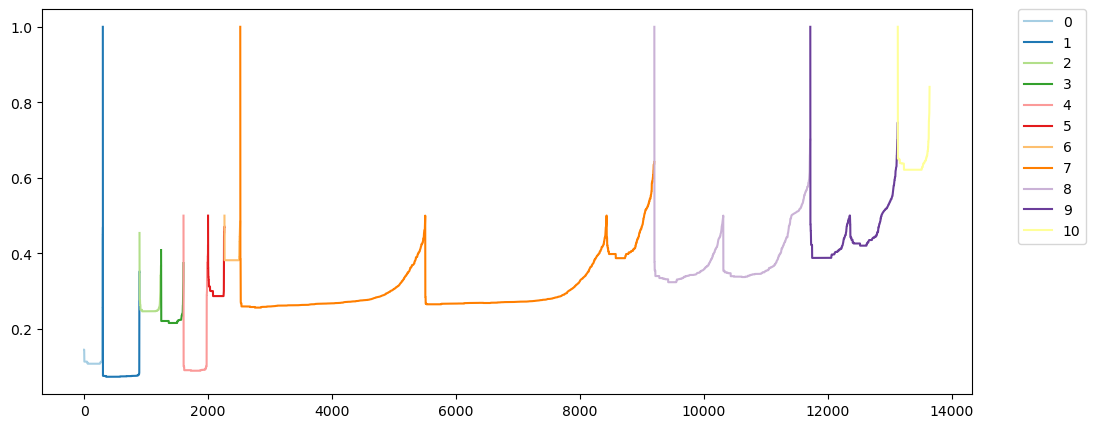

In [138]:
## Extract the ordered reachability and cluster labels
reachability = optics_model.reachability_[optics_model.ordering_]
labels = optics_model.labels_[optics_model.ordering_]

## Remove the cases where the sample is not in a cluster
reachability = reachability[labels > -1]
labels = labels[labels > -1]

## Plot the graph
plt.figure(figsize=(12,5))
sns.lineplot(x=range(reachability[1:].shape[0]), y=reachability[1:], hue=labels[1:], legend="full", palette="Paired")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

> What conclusions can we make from this graph? An important observation is that there is a wide range of reachability values for all the clusters. Further, the reachability of some clusters is much higher than for others. Answer these questions:   
> 6. Do clusters have different densities of samples, and is this is expected and desirable given the complexity of the data?  
> 7. Most of these clusters must have some chain effect. This is evidenced by the fact that the range of reachability values varies greatly within most of the clusters. What does this tell you about how compact and well-formed the clusters are?    
> **End of exercise.**    

> **Answers:**     

> 6. Yes, this variation in densities is expected and desirable given the complexity of the data. The OPTICS algorithm is designed to handle such variability by identifying clusters of different densities, which is one of its strengths compared to other clustering algorithms that assume uniform density. 

> 7. The reachability plot indicates a significant range of reachability values within most clusters. This suggests that there is a chain effect, where some data points in a cluster are only indirectly connected to each other through a series of intermediate points, suggesting that the clusters are not entirely compact or well-formed. Instead, they may be elongated or irregular in shape and the OPTICS algorithm retains this classification of true shape.

#### Copyright 2018, 2019, 2020, 2021, 2022, 2023, Stephen F Elston. All rights reserved. 